<a href="https://colab.research.google.com/github/mferiansyahrt/increasing_synth_image/blob/main/SISR/Unpaired_SISR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEFINE FUNCTION

In [ ]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D,Multiply
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU,PReLU,UpSampling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Concatenate, Flatten, Reshape, Lambda, Dense
from tensorflow.keras.layers import LayerNormalization, Add, GaussianNoise, Layer
from tensorflow.keras.activations import gelu
from tensorflow.keras.applications import VGG19
import tensorflow.keras.backend as K

from os import listdir
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.utils import resample

from datetime import datetime
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2

from matplotlib import pyplot
import numpy as np
import shutil
from PIL import Image

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
!git clone https://www.github.com/keras-team/keras-contrib.git

#Download instance norm. code from the link above.
#Or install keras_contrib using guidelines here: https://github.com/keras-team/keras-contrib
#from instancenormalization import InstanceNormalization
%cd keras-contrib
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634 (from 1)
Receiving objects: 100% (3634/3634), 861.24 KiB | 6.68 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
/content/keras-contrib


In [ ]:
# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=0.5)
	return model

In [ ]:
#U-Net ViT Generator

def basic_block(layer,numfilter,alpha_lrelu,name = None):
  #l = GroupNormalization(groups = -1, axis=-1)(layer)
  l = InstanceNormalization(axis=-1)(layer)
  l = Conv2D(numfilter,(3,3), strides = 1, padding = 'same')(l)
  l = LeakyReLU(alpha = alpha_lrelu,name = name)(l)
  return l

def down_sampling(layer,numfilter):
  l = Conv2D(numfilter, (2,2), strides = 2, padding = 'same')(layer)
  return l

def up_sampling(layer, numfilter):
  l = Conv2DTranspose(numfilter, (3,3), strides = 2, padding = 'same')(layer)
  return l

def positional_embedding(seq_length,dim):
  sequence_length = seq_length
  dimension = dim

  position = tf.range(0,sequence_length,1)[:,np.newaxis]
  position = tf.cast(position,tf.float32)

  even_pos = tf.cast(tf.range(0,dimension,2),tf.float32)
  odd_pos = tf.cast(tf.range(1,dimension,2),tf.float32)
  even_denominator = tf.pow(1000.0,(even_pos/tf.cast(dimension,tf.float32)))
  odd_denominator = tf.pow(1000.0,((odd_pos-1)/tf.cast(dimension,tf.float32)))
  denominator = even_denominator # actually even_denominator == odd_denominator

  even_PE = tf.math.sin(position/denominator)
  odd_PE = tf.math.cos(position/denominator)

  stacked = tf.stack([even_PE,odd_PE],axis = -1)

  PE = tf.reshape(stacked,[sequence_length,dimension])

  return PE

# BASIC BLOCK SEBELUM DOWN ATAU SESUDAH UP SAMPLING MASIH BISA DITAMBAH SATU JIKA MENGIKUTI PAPER (SUDAH DITAMBAHKAN)

def unet_vit_generator(image_shape,num_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu,name = None):
  in_image = Input(shape = image_shape)

  # ---- preprocess ----
  x = Conv2D(64, (2,2), padding ='same')(in_image)
  x = LeakyReLU(alpha = alpha_lrelu)(x)

  # ---- ENCODER PART ----
  #first block
  x = basic_block(x, num_features, alpha_lrelu)
  x_d1 = basic_block(x, num_features, alpha_lrelu)
  x = down_sampling(x_d1, num_features)

  #second block
  x = basic_block(x, num_features*2, alpha_lrelu)
  x_d2 = basic_block(x,num_features*2, alpha_lrelu)
  x = down_sampling(x_d2,num_features*2)

  #third block
  x = basic_block(x, num_features*4, alpha_lrelu)
  x_d3 = basic_block(x,num_features*4, alpha_lrelu)
  x = down_sampling(x_d3,num_features*4)

  #fourth block
  x = basic_block(x, num_features*8, alpha_lrelu)
  x_d4 = basic_block(x, num_features*8, alpha_lrelu)
  x = down_sampling(x_d4, num_features*8)
  flatten_shape = x.shape

  # ---- pixel-wise ViT ----
  x = Reshape((flatten_shape[1]*flatten_shape[2],flatten_shape[3]))(x)

  # Define Positional Encoding layer (256,512) by default
  PE = positional_embedding(flatten_shape[1]*flatten_shape[2],num_features*8) #Should be normalized later according to LeakyReLU range
  PE = LeakyReLU(alpha = alpha_lrelu)(PE)
  PE_layer = tf.expand_dims(PE, axis=0)

  class RepeatLayer(Layer):
      def __init__(self, axis=0, **kwargs):
          super(RepeatLayer, self).__init__(**kwargs)
          self.axis = axis

      def call(self, inputs, x):
          repeat_times = tf.shape(x)[0]  # Get the batch size dynamically from 'x'
          return tf.repeat(inputs, repeat_times, axis=self.axis)

      def get_config(self):
          config = super().get_config().copy()
          config.update({
              'axis': self.axis
          })
          return config

  # Custom repeat layer instead of tf.repeat
  PE_layer = RepeatLayer(axis=0)(PE_layer, x)

  # Concatenate positional encoding with input
  x = Concatenate(axis=2)([x, PE_layer])
  x = Dense(num_features * 8)(x)

  # Transformer Encoder Block
  for n in range(transformer_block):
    x_l = LayerNormalization(epsilon = 1e-6)(x)
    x = MultiHeadAttention(num_heads = n_attention_head, key_dim = num_features, dropout = 0.1)(x_l,x_l)
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha_reg) * x
    x = Add()([x_l,x])
    x_l2 = LayerNormalization(epsilon = 1e-6)(x)

    # FFN
    x = Dense(4*num_features*8, activation = 'gelu')(x_l2) # masih salah (seharusnya (512,2048))
    x = Dense(num_features*8)(x)                           # masih salah(seharusnya (2048,512))
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha_reg) * x
    x = Add()([x_l2,x])

  x = Dense(num_features*8)(x)
  x = Reshape((flatten_shape[1],flatten_shape[2],flatten_shape[3]))(x)

  # ---- DECODER PART ----
  #first block
  x = up_sampling(x,num_features*8)
  x = Concatenate()([x, x_d4])
  x = basic_block(x,num_features*8, alpha_lrelu)
  x = basic_block(x,num_features*8, alpha_lrelu)

  #second block
  x = up_sampling(x,num_features*4)
  x = Concatenate()([x, x_d3])
  x = basic_block(x,num_features*4, alpha_lrelu)
  x = basic_block(x,num_features*4, alpha_lrelu)

  #third block
  x = up_sampling(x,num_features*2)
  x = Concatenate()([x, x_d2])
  x = basic_block(x,num_features*2, alpha_lrelu)
  x = basic_block(x,num_features*2, alpha_lrelu)

  #fourth block
  x = up_sampling(x,num_features)
  x = Concatenate()([x, x_d1])
  x = basic_block(x,num_features, alpha_lrelu)
  x = basic_block(x,num_features, alpha_lrelu, name = name)

  # ---- postprocess ----
  x = Conv2D(3, (1,1), padding='same')(x)
  x = InstanceNormalization(axis=-1)(x)
  out_image = Activation('tanh')(x)

  m = Model(in_image,out_image)
  return m

def unet_vit_generator_sr(in_image,num_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu,name = None):
  # ---- preprocess ----
  x = Conv2D(64, (2,2), padding ='same')(in_image)
  x = LeakyReLU(alpha = alpha_lrelu)(x)

  # ---- ENCODER PART ----
  #first block
  x = basic_block(x, num_features, alpha_lrelu)
  x_d1 = basic_block(x, num_features, alpha_lrelu)
  x = down_sampling(x_d1, num_features)

  #second block
  x = basic_block(x, num_features*2, alpha_lrelu)
  x_d2 = basic_block(x,num_features*2, alpha_lrelu)
  x = down_sampling(x_d2,num_features*2)

  #third block
  x = basic_block(x, num_features*4, alpha_lrelu)
  x_d3 = basic_block(x,num_features*4, alpha_lrelu)
  x = down_sampling(x_d3,num_features*4)

  #fourth block
  x = basic_block(x, num_features*8, alpha_lrelu)
  x_d4 = basic_block(x, num_features*8, alpha_lrelu)
  x = down_sampling(x_d4, num_features*8)
  flatten_shape = x.shape

  # ---- pixel-wise ViT ----
  x = Reshape((flatten_shape[1]*flatten_shape[2],flatten_shape[3]))(x)

  # Define Positional Encoding layer (256,512) by default
  PE = positional_embedding(flatten_shape[1]*flatten_shape[2],num_features*8) #Should be normalized later according to LeakyReLU range
  PE = LeakyReLU(alpha = alpha_lrelu)(PE)
  PE_layer = tf.expand_dims(PE, axis=0)

  class RepeatLayer(Layer):
      def __init__(self, axis=0, **kwargs):
          super(RepeatLayer, self).__init__(**kwargs)
          self.axis = axis

      def call(self, inputs, x):
          repeat_times = tf.shape(x)[0]  # Get the batch size dynamically from 'x'
          return tf.repeat(inputs, repeat_times, axis=self.axis)

      def get_config(self):
          config = super().get_config().copy()
          config.update({
              'axis': self.axis
          })
          return config

  # Custom repeat layer instead of tf.repeat
  PE_layer = RepeatLayer(axis=0)(PE_layer, x)

  # Concatenate positional encoding with input
  x = Concatenate(axis=2)([x, PE_layer])
  x = Dense(num_features * 8)(x)

  # Transformer Encoder Block
  for n in range(transformer_block):
    x_l = LayerNormalization(epsilon = 1e-6)(x)
    x = MultiHeadAttention(num_heads = n_attention_head, key_dim = num_features, dropout = 0.1)(x_l,x_l)
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha_reg) * x
    x = Add()([x_l,x])
    x_l2 = LayerNormalization(epsilon = 1e-6)(x)

    # FFN
    x = Dense(4*num_features*8, activation = 'gelu')(x_l2) # masih salah (seharusnya (512,2048))
    x = Dense(num_features*8)(x)                           # masih salah(seharusnya (2048,512))
    # Rezero regularization Output = SkipConnection + α⋅MainPath
    x = tf.constant(alpha_reg) * x
    x = Add()([x_l2,x])

  x = Dense(num_features*8)(x)
  x = Reshape((flatten_shape[1],flatten_shape[2],flatten_shape[3]))(x)

  # ---- DECODER PART ----
  #first block
  x = up_sampling(x,num_features*8)
  x = Concatenate()([x, x_d4])
  x = basic_block(x,num_features*8, alpha_lrelu)
  x = basic_block(x,num_features*8, alpha_lrelu)

  #second block
  x = up_sampling(x,num_features*4)
  x = Concatenate()([x, x_d3])
  x = basic_block(x,num_features*4, alpha_lrelu)
  x = basic_block(x,num_features*4, alpha_lrelu)

  #third block
  x = up_sampling(x,num_features*2)
  x = Concatenate()([x, x_d2])
  x = basic_block(x,num_features*2, alpha_lrelu)
  x = basic_block(x,num_features*2, alpha_lrelu)

  #fourth block
  x = up_sampling(x,num_features)
  x = Concatenate()([x, x_d1])
  x = basic_block(x,num_features, alpha_lrelu)
  x = basic_block(x,num_features, alpha_lrelu, name = name)

  # ---- postprocess ----
  x = Conv2D(64, (3,3), padding='same')(x)
  x = InstanceNormalization(axis=-1)(x)
  out_image = Activation('leaky_relu')(x)

  return out_image

In [ ]:
# generator a resnet block to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the  generator model - encoder-decoder type architecture

#c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1.
#dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers
# uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

#The network with 9 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately.
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time.
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False

	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

  # define the optimizer
	opt = Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 1e-8)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
def composite_sr_model(g_model_1,g_model_2,d_model_sr,sr_model,image_shape,hr_shape):
  g_model_1.trainable = False
  g_model_2.trainable = False
  d_model_sr.trainable = False

  # pseudo domain
  #input_clr = Input(shape=image_shape)
  input_real_hr = Input(shape=hr_shape)
  #image_shape = tf.constant([image_shape[0], image_shape[1]])
  clr_image = Lambda(lambda image: tf.image.resize(image, image_shape[0:2]))(input_real_hr)
  gen1_out_clr = g_model_1(clr_image) #clr to lr
  gen2_out_clr = g_model_2(gen1_out_clr) #pseudo clr
  sr_pseudo_clr = sr_model(gen2_out_clr)

  # LR domain
  input_real_lr = Input(shape=image_shape)
  gen1_out_lr = g_model_2(input_real_lr) #lr to clr
  sr_lr = sr_model(gen1_out_lr)
  output_d_lr = d_model_sr([sr_lr])

  model = Model([input_real_hr,input_real_lr],[sr_pseudo_clr,sr_lr,output_d_lr])
  # define the optimizer
  opt = Adam(learning_rate=0.0001, beta_1 = 0.9, epsilon = 1e-8)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss=['mae', 'mae', 'mse'],
                loss_weights=[5, 5, 1], optimizer=opt)
  return model

def composite_sr_model2(g_model_1,g_model_2,d_model_sr,sr_model,vgg,image_shape,hr_shape):
  g_model_1.trainable = False
  g_model_2.trainable = False
  d_model_sr.trainable = False

  # pseudo domain
  #input_clr = Input(shape=image_shape)
  input_real_hr = Input(shape=hr_shape)
  #image_shape = tf.constant([image_shape[0], image_shape[1]])
  clr_image = Lambda(lambda image: tf.image.resize(image, image_shape[0:2]))(input_real_hr)
  gen1_out_clr = g_model_1(clr_image) #clr to lr
  gen2_out_clr = g_model_2(gen1_out_clr) #pseudo clr
  sr_pseudo_clr = sr_model(gen2_out_clr)
  vgg_sr_pclr = vgg(sr_pseudo_clr)

  # LR domain
  input_real_lr = Input(shape=image_shape)
  gen1_out_lr = g_model_2(input_real_lr) #lr to clr
  sr_lr = sr_model(gen1_out_lr)
  output_d_lr = d_model_sr([sr_lr])

  # VGG features on sr lr
  vgg_sr_lr = vgg(sr_lr)

  model = Model([input_real_hr,input_real_lr],[vgg_sr_pclr,output_d_lr,vgg_sr_lr,sr_pseudo_clr,sr_lr])
  # define the optimizer
  opt = Adam(learning_rate=0.0001, beta_1 = 0.9, epsilon = 1e-8)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss=['mse', 'mse', 'mse','mae','mae'],
                loss_weights=[1, 0.5, 1, 5, 5], optimizer=opt)
  return model

# CREATE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/day2night/
%cd /content/day2night/
#!unzip /content/gdrive/MyDrive/day2night_bdd_ip2.zip # Dataset campuran yang baru
!unzip /content/gdrive/MyDrive/day2night_bdd_ip.zip # Dataset campuran yang lama
#!unzip /content/gdrive/MyDrive/day2night.zip # Dataset asli

/content/day2night
Archive:  /content/gdrive/MyDrive/day2night_bdd_ip.zip
   creating: trainDay/
  inflating: trainDay/6a729de1-7adc57f8.jpg  
  inflating: __MACOSX/trainDay/._6a729de1-7adc57f8.jpg  
  inflating: trainDay/Image_15.jpg   
  inflating: trainDay/Image_29.jpg   
  inflating: trainDay/1c1de1e7-346d6219.jpg  
  inflating: __MACOSX/trainDay/._1c1de1e7-346d6219.jpg  
  inflating: trainDay/6ad23488-70abed67.jpg  
  inflating: __MACOSX/trainDay/._6ad23488-70abed67.jpg  
  inflating: trainDay/6a626ee3-61100bbc.jpg  
  inflating: __MACOSX/trainDay/._6a626ee3-61100bbc.jpg  
  inflating: trainDay/0f145ef9-2fb016d0.jpg  
  inflating: __MACOSX/trainDay/._0f145ef9-2fb016d0.jpg  
  inflating: trainDay/00f7eac8-5193d600.jpg  
  inflating: __MACOSX/trainDay/._00f7eac8-5193d600.jpg  
  inflating: trainDay/Image_28.jpg   
  inflating: trainDay/Image_14.jpg   
  inflating: trainDay/1a2f2112-f566a272.jpg  
  inflating: __MACOSX/trainDay/._1a2f2112-f566a272.jpg  
  inflating: trainDay/0a0c3694

In [ ]:
import os

os.remove('/content/day2night/trainDay/.DS_Store')
os.remove('/content/day2night/trainNight/.DS_Store')

day = sorted(os.listdir('/content/day2night/trainDay/'))
night = sorted(os.listdir('/content/day2night/trainNight/'))

In [ ]:
# bdd_day2night

# load all images in a directory into memory
def load_images(path, size=(512,512)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path_HR = '/content/day2night/'

# load dataset night HIGH RESOLUTION (HR) -- TARGET
dataHR_all = load_images(path_HR + 'trainNight/')
print('Loaded dataHR: ', dataHR_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataHR = resample(dataHR_all,
                 replace=False,
                 n_samples=len(night),
                 random_state=42)
print(f'Use Real Night HR Images(dataHR) with total of {dataHR.shape[0]} images for training')

# load dataset night LOW RESOLUTION (LR) -- FEATURE
path_lr = '/content/gdrive/MyDrive/night_generated_uvcgan/'
dataLR_all = load_images(path_lr + 'night/', size=(256,256))
print('Loaded dataLR: ', dataLR_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataLR = resample(dataLR_all,
                 replace=False,
                 n_samples=len(night),
                 random_state=42)
print(f'Use Synthetic Night Generated LR Images (dataLR) with total of {dataLR.shape[0]} images for training')

Loaded dataHR:  (169, 512, 512, 3)
Use Real Night HR Images(dataHR) with total of 169 images for training
Loaded dataLR:  (169, 256, 256, 3)
Use Synthetic Night Generated LR Images (dataLR) with total of 169 images for training


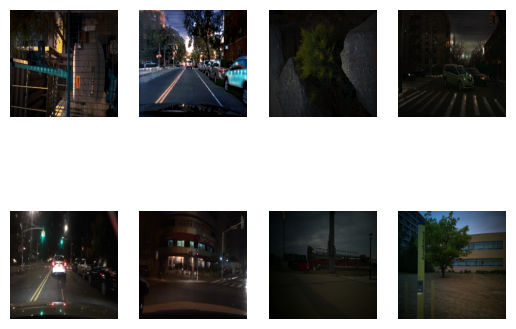

Loaded (169, 256, 256, 3) (169, 512, 512, 3)


In [ ]:
# plot source images
n_samples = 4
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataLR[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataHR[i].astype('uint8'))
plt.show()

# load image data
data = [dataLR, dataHR]

print('Loaded', data[0].shape, data[1].shape)

#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

def preprocess_data_input_edge(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [0,1]
	X1 = (X1) / 255.0
	X2 = (X2) / 255.0
	return [X1, X2]

dataset = preprocess_data(data)

In [ ]:
# # bdd_day2night

# # load all images in a directory into memory
# def load_images(path, size=(256,256)):
# 	data_list = list()
# 	# enumerate filenames in directory, assume all are images
# 	for filename in listdir(path):
# 		# load and resize the image
# 		pixels = load_img(path + filename, target_size=size)
# 		# convert to numpy array
# 		pixels = img_to_array(pixels)
# 		# store
# 		data_list.append(pixels)
# 	return asarray(data_list)

# # dataset path
# path = '/content/day2night/'

# # load dataset A - day
# dataA_all = load_images(path + 'trainDay/')
# print('Loaded dataA: ', dataA_all.shape)

# #To get a subset of all images, for faster training during demonstration
# dataA = resample(dataA_all,
#                  replace=False,
#                  n_samples=len(day),
#                  random_state=42)
# print(f'Use Day Images (dataA) with total of {dataA.shape[0]} images for training')

# # load dataset B - night
# dataB_all = load_images(path + 'trainNight/', size=(512,512))
# print('Loaded dataB: ', dataB_all.shape)
# #Get a subset of all images, for faster training during demonstration
# #We could have just read the list of files and only load a subset, better memory management.
# dataB = resample(dataB_all,
#                  replace=False,
#                  n_samples=len(night),
#                  random_state=42)
# print(f'Use Night Images (dataB) with total of {dataB.shape[0]} images for training')

In [ ]:
# # plot source images
# n_samples = 3
# for i in range(n_samples):
# 	plt.subplot(2, n_samples, 1 + i)
# 	plt.axis('off')
# 	plt.imshow(dataA[i].astype('uint8'))
# # plot target image
# for i in range(n_samples):
# 	plt.subplot(2, n_samples, 1 + n_samples + i)
# 	plt.axis('off')
# 	plt.imshow(dataB[i].astype('uint8'))
# plt.show()

# # load image data
# data = [dataA, dataB]

# print('Loaded', data[0].shape, data[1].shape)

# #Preprocess data to change input range to values between -1 and 1
# # This is because the generator uses tanh activation in the output layer
# #And tanh ranges between -1 and 1
# def preprocess_data(data):
# 	# load compressed arrays
# 	# unpack arrays
# 	X1, X2 = data[0], data[1]
# 	# scale from [0,255] to [-1,1]
# 	X1 = (X1 - 127.5) / 127.5
# 	X2 = (X2 - 127.5) / 127.5
# 	return [X1, X2]

# def preprocess_data_input_edge(data):
# 	# load compressed arrays
# 	# unpack arrays
# 	X1, X2 = data[0], data[1]
# 	# scale from [0,255] to [0,1]
# 	X1 = (X1) / 255.0
# 	X2 = (X2) / 255.0
# 	return [X1, X2]

# dataset = preprocess_data(data)

# ESRGAN

In [ ]:
# i = Input(shape = (256,256,3))
# x_rrdb1 = dense_block(i)
# x_rrdb1 = tf.multiply(x_rrdb1,beta)
# x_rrdb1 = Add()([x,x_rrdb1])

# x_rrdb2 = dense_block(x_rrdb1)
# x_rrdb2 = tf.multiply(x_rrdb2,beta)
# x_rrdb2 = Add()([x_rrdb1,x_rrdb2])

# x_rrdb3 = dense_block(x_rrdb2)
# x_rrdb3 = tf.multiply(x_rrdb3,beta)
# x_rrdb3 = Add()([x_rrdb2,x_rrdb3])

# x_rrdb3 = tf.multiply(x_rrdb3,beta)
# x_rrdb = Add()([x,x_rrdb3])

# m = Model(i,x_rrdb)

In [ ]:
def dense_block(x):
  x1 = Conv2D(64,(3,3),padding = 'same')(x)
  x1 = LeakyReLU(0.2)(x1)
  x1c = Concatenate()([x,x1])

  x2 = Conv2D(64,(3,3),padding = 'same')(x1c)
  x2 = LeakyReLU(0.2)(x2)
  x2c = Concatenate()([x,x1c,x2])

  x3 = Conv2D(64,(3,3),padding = 'same')(x2c)
  x3 = LeakyReLU(0.2)(x3)
  x3c = Concatenate()([x,x1c,x2c,x3])

  x4 = Conv2D(64,(3,3),padding = 'same')(x3c)
  x4 = LeakyReLU(0.2)(x4)
  x4c = Concatenate()([x,x1c,x2c,x4])

  xo = Conv2D(64,(3,3),padding = 'same')(x4c)

  return xo
  #rrdb

# def rrdb(x,beta):

#   x_rrdb1 = dense_block(x)
#   # Use Keras Multiply layer instead of tf.multiply
#   x_rrdb1 = Multiply(constant = beta)(x_rrdb1)
#   x_rrdb1 = Add()([x,x_rrdb1])

#   x_rrdb2 = dense_block(x_rrdb1)
#   # Use Keras Multiply layer instead of tf.multiply
#   x_rrdb2 = Multiply(constant = beta)(x_rrdb2)
#   x_rrdb2 = Add()([x_rrdb1,x_rrdb2])

#   x_rrdb3 = dense_block(x_rrdb2)
#   # Use Keras Multiply layer instead of tf.multiply
#   x_rrdb3 = Multiply(constant = beta)(x_rrdb3)
#   x_rrdb3 = Add()([x_rrdb2,x_rrdb3])

#   # Use Keras Multiply layer instead of tf.multiply
#   x_rrdb3 = Multiply(constant = beta)(x_rrdb3)
#   x_rrdb = Add()([x,x_rrdb3])

#   return x_rrdb

def rrdb(x,beta):

  x_rrdb1 = dense_block(x)
  # Use Keras Lambda layer to multiply by a constant
  x_rrdb1 = Lambda(lambda x: x * beta)(x_rrdb1)
  x_rrdb1 = Add()([x,x_rrdb1])

  x_rrdb2 = dense_block(x_rrdb1)
  # Use Keras Lambda layer to multiply by a constant
  x_rrdb2 = Lambda(lambda x: x * beta)(x_rrdb2)
  x_rrdb2 = Add()([x_rrdb1,x_rrdb2])

  x_rrdb3 = dense_block(x_rrdb2)
  # Use Keras Lambda layer to multiply by a constant
  x_rrdb3 = Lambda(lambda x: x * beta)(x_rrdb3)
  x_rrdb3 = Add()([x_rrdb2,x_rrdb3])

  # Use Keras Lambda layer to multiply by a constant
  x_rrdb3 = Lambda(lambda x: x * beta)(x_rrdb3)
  x_rrdb = Add()([x,x_rrdb3])

  return x_rrdb

def upscale_block(x,factor):

  up_model = Conv2D(256, (3,3), padding="same")(x)
  up_model = UpSampling2D( size = factor )(up_model)
  up_model = PReLU(shared_axes=[1,2])(up_model)

  return up_model

In [ ]:
def super_resolution(input_shape,target_shape,num_rrdb,beta):
  #Define enlightenGAN, ESRGAN, dan ESRGAN+ disini

  i = Input(shape = input_shape)
  x = Conv2D(64,(9,9),padding = 'same')(i)
  # g = GroupNormalization(groups = -1, axis=-1)(g)
  x = Activation('leaky_relu')(x)
  temp = x

  for j in range(num_rrdb):
    x = rrdb(x,beta)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Add()([x,temp])

  x = upscale_block(x,target_shape)
  #x = upscale_block(x,target_shape)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Conv2D(3, (7,7), padding='same')(x)
  out_image = Activation('tanh')(x)

  sr_model = Model(i,out_image)
  sr_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=0.5)
  return sr_model

In [ ]:
# input_shape = (256,256,3)
# target_shape = 2 #upscale on what factor
# num_rrdb = 3
# beta = 0.1

# sr = super_resolution(input_shape,target_shape,num_rrdb,beta)

In [ ]:
# sr.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │         15,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 128)  │              0 │ activation[0][0],      │
│                           │                        │                │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         73,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 256)  │              0 │ activation[0][0],      │
│ (Concatenate)             │                        │                │ concatenate[0][0],     │
│                           │                        │                │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │        147,520 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256, 256, 512)  │              0 │ activation[0][0],      │
│ (Concatenate)             │                        │                │ concatenate[0][0],     │
│                           │                        │                │ concatenate_1[0][0],   │
│                           │                        │                │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │        294,976 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 256, 256, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 256, 256, 512)  │              0 │ activation[0][0],      │
│ (Concatenate)             │                        │                │ concatenate[0][0],     │
│                           │                        │                │ concatenate_1[0][0],   │
│                           │                        │                │ leaky_re_lu_3[0][0]    │
├──────────────────────

 Total params: 7,991,171 (30.48 MB)

 Trainable params: 7,991,171 (30.48 MB)

 Non-trainable params: 0 (0.00 B)

# ESRGAN+

In [ ]:
def residual_dense_block(x):
  x1 = Conv2D(64,(3,3),padding = 'same')(x)
  x1 = LeakyReLU(0.2)(x1)
  x1c = Concatenate()([x,x1])

  x2 = Conv2D(64,(3,3),padding = 'same')(x1c)
  x2 = LeakyReLU(0.2)(x2)
  x2c_conc = Concatenate()([x,x1c,x2]) # disini fiturnya menjadi 256
  x2c_upfeat = Conv2D(x2c_conc.shape[-1],(3,3),padding = 'same')(x)
  x2c = Add()([x2c_upfeat,x2c_conc])

  x3 = Conv2D(64,(3,3),padding = 'same')(x2c)
  x3 = LeakyReLU(0.2)(x3)
  x3c = Concatenate()([x,x1c,x2c,x3])

  x4 = Conv2D(64,(3,3),padding = 'same')(x3c)
  x4 = LeakyReLU(0.2)(x4)
  x4c_conc = Concatenate()([x,x1c,x2c,x4]) # disini fiturnya menjadi 512
  x4c_upfeat = Conv2D(x4c_conc.shape[-1],(3,3),padding = 'same')(x2c)
  x4c = Add()([x4c_upfeat,x4c_conc])

  xo = Conv2D(64,(3,3),padding = 'same')(x4c)

  return xo

def rrdrb(x,beta,gamma,stddev):
  x_gauss = Lambda(lambda x: tf.random.normal(shape = tf.shape(x), mean = 0.0, stddev = stddev))(x)
  x_gauss = Lambda(lambda x: x * gamma)(x_gauss)

  x_rrdb1 = residual_dense_block(x)
  x_rrdb1 = Lambda(lambda x: x * beta)(x_rrdb1)
  x_rrdb1 = Add()([x,x_rrdb1])
  x_rrdb1 = Add()([x_rrdb1,x_gauss])

  x_rrdb2 = residual_dense_block(x_rrdb1)
  x_rrdb2 = Lambda(lambda x: x * beta)(x_rrdb2)
  x_rrdb2 = Add()([x_rrdb1,x_rrdb2])
  x_rrdb2 = Add()([x_rrdb2,x_gauss])

  x_rrdb3 = residual_dense_block(x_rrdb2)
  x_rrdb3 = Lambda(lambda x: x * beta)(x_rrdb3)
  x_rrdb3 = Add()([x_rrdb2,x_rrdb3])
  x_rrdb3 = Add()([x_rrdb3,x_gauss])

  x_rrdb3 = Lambda(lambda x: x * beta)(x_rrdb3)
  x_rrdb = Add()([x,x_rrdb3])

  return x_rrdb

def upscale_block(x,factor):

  up_model = Conv2D(256, (3,3), padding="same")(x)
  up_model = UpSampling2D( size = factor )(up_model)
  up_model = PReLU(shared_axes=[1,2])(up_model)

  return up_model

def up_sampling_sr(layer, numfilter):
  l = Conv2DTranspose(numfilter, (3,3), strides = 2, padding = 'same')(layer)
  l = PReLU(shared_axes=[1,2])(l)
  return l

In [ ]:
# Load pre-trained VGG19 and use the intermediate layers for perceptual loss
def vgg_layers(layer_names):
    """ Creates a VGG model that outputs specified layer outputs """
    vgg = VGG19(include_top=False, weights='imagenet')
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    model.trainable = False
    return model

# Define layers from VGG19 to use for feature extraction
# You can select 'block1_conv2', 'block2_conv2', 'block3_conv3', etc.
vgg_model = vgg_layers(['block3_conv3', 'block4_conv3'])


def perceptual_loss(y_true, y_pred):
    """Perceptual loss based on VGG feature maps."""
    # Extract features from both true and predicted images
    y_true_features = vgg_model(y_true)
    y_pred_features = vgg_model(y_pred)

    # Compute the mean squared error between features (perceptual loss)
    perceptual_loss_value = 0
    for true_feat, pred_feat in zip(y_true_features, y_pred_features):
        perceptual_loss_value += K.mean(K.square(true_feat - pred_feat))

    return perceptual_loss_value

def bilateral_loss(y_true, y_pred):
    """Bilateral loss to preserve local structures and textures."""
    # Spatial distance weight: Gaussian kernel for spatial distances
    def gaussian_kernel(size, sigma):
        """Generates a 2D Gaussian kernel."""
        ax = tf.range(-size // 2 + 1., size // 2 + 1.)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
        return kernel / tf.reduce_sum(kernel)

    kernel_size = 5
    sigma = 1.5
    bilateral_kernel = gaussian_kernel(kernel_size, sigma)

    # Convert to grayscale if the input image has more than one channel
    if y_true.shape[-1] > 1: # Check if the input has more than one channel (e.g., RGB)
        y_true = tf.image.rgb_to_grayscale(y_true)
        y_pred = tf.image.rgb_to_grayscale(y_pred)

    # Apply Gaussian filter to the true image and predicted image
    y_true_filtered = tf.nn.conv2d(y_true, bilateral_kernel[:, :, None, None], strides=[1, 1, 1, 1], padding='SAME')
    y_pred_filtered = tf.nn.conv2d(y_pred, bilateral_kernel[:, :, None, None], strides=[1, 1, 1, 1], padding='SAME')

    # Bilateral loss: mean squared error between filtered images
    bilateral_loss_value = K.mean(K.square(y_true_filtered - y_pred_filtered))

    return bilateral_loss_value

def contextual_bilateral_loss(y_true, y_pred, perceptual_weight=0.8, bilateral_weight=0.2):
    """Combined contextual bilateral loss function."""
    perceptual = perceptual_loss(y_true, y_pred)
    bilateral = bilateral_loss(y_true, y_pred)

    # Weighted sum of perceptual and bilateral losses
    return perceptual_weight * perceptual + bilateral_weight * bilateral

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# gunakan fungsi ini ketika tidak mengcompile, fungsi ini berkaitan dengan train saja
def super_resolution(input_shape,target_shape,num_rrdrb,beta,gamma,stddev):
  #Define enlightenGAN, ESRGAN, dan ESRGAN+ disini

  i = Input(shape = input_shape)
  x = Conv2D(64,(9,9),padding = 'same')(i)
  x = Activation('leaky_relu')(x)
  temp = x

  for j in range(num_rrdrb):
    x = rrdrb(x,beta,gamma,stddev)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Add()([x,temp])

  x = upscale_block(x,target_shape)
  #x = upscale_block(x,target_shape)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Conv2D(3, (7,7), padding='same')(x)
  out_image = Activation('tanh')(x)

  sr_model = Model(i,x)
  #sr_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0002, beta_1=0.9), loss_weights=0.01)
  return sr_model

# gunakan fungsi ini ketika ingin mengcompile, fungsi ini berkaitan dengan train2
def super_resolution2(input_shape,target_shape,num_rrdrb,beta,gamma,stddev):
  #Define enlightenGAN, ESRGAN, dan ESRGAN+ disini

  i = Input(shape = input_shape)
  x = Conv2D(64,(9,9),padding = 'same')(i)
  x = Activation('leaky_relu')(x)
  temp = x

  for j in range(num_rrdrb):
    x = rrdrb(x,beta,gamma,stddev)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Add()([x,temp])

  x = upscale_block(x,target_shape)
  #x = upscale_block(x,target_shape)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Conv2D(3, (7,7), padding='same')(x)
  out_image = Activation('tanh')(x)

  sr_model = Model(i,x)
  sr_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0002, beta_1=0.9), loss_weights=10)
  # sr_model.compile(loss=contextual_bilateral_loss, optimizer=Adam(learning_rate=0.0002, beta_1=0.9))
  return sr_model

# gunakan fungsi ini ketika ingin mengcompile, fungsi ini berkaitan dengan train2
def super_resolution2_uvcgan(input_shape,n_features,n_attention_head,
                             transformer_block,alpha_reg,alpha_lrelu):
  #Define enlightenGAN, ESRGAN, dan ESRGAN+ disini

  i = Input(shape = input_shape)
  x = Conv2D(64,(9,9),padding = 'same')(i)
  x = Activation('leaky_relu')(x)
  temp = x

  x = unet_vit_generator_sr(x,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Add()([x,temp])

  # perbanyak filter
  x = Conv2D(128,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Conv2D(256,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)

  x = up_sampling_sr(x,128)
  #x = upscale_block(x,target_shape)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)

  x = Conv2D(32,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Conv2D(3, (1,1), padding='same')(x)
  out_image = Activation('tanh')(x)

  sr_model = Model(i,x)
  sr_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0002, beta_1=0.9), loss_weights=5)
  return sr_model

# Enlighten GAN

In [ ]:
def dense_block(x):
  x1 = Conv2D(64,(3,3),padding = 'same')(x)
  x1 = LeakyReLU(0.2)(x1)
  x1c = Concatenate()([x,x1])

  x2 = Conv2D(64,(3,3),padding = 'same')(x1c)
  x2 = LeakyReLU(0.2)(x2)
  x2c = Concatenate()([x,x1c,x2])

  x3 = Conv2D(64,(3,3),padding = 'same')(x2c)
  x3 = LeakyReLU(0.2)(x3)
  x3c = Concatenate()([x,x1c,x2c,x3])

  x4 = Conv2D(64,(3,3),padding = 'same')(x3c)
  x4 = LeakyReLU(0.2)(x4)
  x4c = Concatenate()([x,x1c,x2c,x4])

  xo = Conv2D(64,(3,3),padding = 'same')(x4c)

  return xo
  #rrdb

def rrdb(x,beta):

  x_rrdb1 = dense_block(x)
  x_rrdb1 = tf.multiply(x_rrdb1,beta)
  x_rrdb1 = Add()([x,x_rrdb1])

  x_rrdb2 = dense_block(x_rrdb1)
  x_rrdb2 = tf.multiply(x_rrdb2,beta)
  x_rrdb2 = Add()([x_rrdb1,x_rrdb2])

  x_rrdb3 = dense_block(x_rrdb2)
  x_rrdb3 = tf.multiply(x_rrdb3,beta)
  x_rrdb3 = Add()([x_rrdb2,x_rrdb3])

  x_rrdb3 = tf.multiply(x_rrdb3,beta)
  x_rrdb = Add()([x,x_rrdb3])

  return x_rrdb

def upscale_block(x,factor):

  up_model = Conv2D(256, (3,3), padding="same")(x)
  up_model = UpSampling2D( size = factor )(up_model)
  up_model = PReLU(shared_axes=[1,2])(up_model)

  return up_model

def enlighten_block(x):
    # Define an enhancement block here similar to the Enlighten Block
    x = Conv2D(64, (3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(64, (3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    return x

In [ ]:
def super_resolution(input_shape,target_shape,num_rrdb,beta):
  #Define enlightenGAN, ESRGAN, dan ESRGAN+ disini

  i = Input(shape = input_shape)
  x = Conv2D(64,(9,9),padding = 'same')(i)

  temp = x

  for j in range(num_rrdb):
    x = rrdb(x,beta)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Add()([x,temp])

  x = upscale_block(x,int(target_shape/2)) #enlightten gan part
  x = enlighten_block(x)
  x = upscale_block(x,int(target_shape/2))

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Conv2D(3,(9,9),padding = 'same')(x)

  sr_model = Model(i,x)

  return sr_model

In [ ]:
input_shape = (256,256,3)
target_shape = 4 #upscale on what factor
num_rrdb = 3
beta = 0.1

sr = super_resolution(input_shape,target_shape,num_rrdb,beta)

In [ ]:
sr.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_258 (Conv2D)         (None, 256, 256, 64)         15616     ['input_6[0][0]']             
                                                                                                  
 conv2d_259 (Conv2D)         (None, 256, 256, 64)         36928     ['conv2d_258[0][0]']          
                                                                                                  
 leaky_re_lu_188 (LeakyReLU  (None, 256, 256, 64)         0         ['conv2d_259[0][0]']          
 )                                                                                          

# TRAINING

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1.
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0.
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

#datasetnya pake yang trainB, dan pake dua model untuk ngehasilin pseudoCLR
#dataset trainA untuk testing ke generator AtoB dan ke SR
def generate_sr_samples(trainA, trainB, g_model_1, g_model_2, sr_model, patch_shape):
	#pseudoCLR to SR
	clr_lr = g_model_1.predict(trainB)
	pseudo_cleanLR = g_model_2.predict(clr_lr)
	pseudoCLR_SR = sr_model.predict(pseudo_cleanLR)

	#realLR to SR
	real_lr = g_model_2.predict(trainA)
	realLR_SR = sr_model.predict(real_lr)

	y_realLR_SR = ones((len(realLR_SR), patch_shape, patch_shape, 1))
	y_pseudoCLR_SR = zeros((len(pseudoCLR_SR), patch_shape, patch_shape, 1))
	return realLR_SR, pseudoCLR_SR, y_realLR_SR, y_pseudoCLR_SR

def resize(X,res):
	X_resize =[]
	for i in X:
		X_resize.append(cv2.resize(i,res))
	# generate 'real' class labels (1)
	X_resize = np.array(X_resize)
	return X_resize

def downscale_operation(image,clr_shape):
	# im = cv2.resize(image,(clr_shape,clr_shape))
	# im = image
	X_resize =[]
	for i in image:
		X_resize.append(cv2.resize(i,clr_shape))
	# generate 'real' class labels (1)
	X_resize = np.array(X_resize)
	return X_resize

def generate_LR_samples(dataset, n_samples, patch_shape, hr_shape,clr_shape):
	ix = randint(0, dataset.shape[0], n_samples)
	X_hr_ori = dataset[ix]
	X_hr = downscale_operation(X_hr_ori,hr_shape)
	#X_hr = X_hr_ori
	X = downscale_operation(X_hr_ori,clr_shape) #downscale from original size
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X,y,X_hr

def generate_pseudo_samples(dataset,g_model_BtoA, g_model_AtoB):
	clr_lr = g_model_BtoA.predict(dataset)
	pseudo_cleanLR = g_model_AtoB.predict(clr_lr)
	return pseudo_cleanLR

def summarize_performance_SR(step, g_model_1, g_model_2, sr_model, trainA, trainB, name, clr_shape, n_patch, n_samples=5):

	# dataset trainB dari real High Resolution dan harus di resize ke ukuran clr shape
	if trainB.shape[1] > 256:
		trainB = downscale_operation(trainB,clr_shape)
	elif trainB.shape[1] == 256:
		trainB = trainB

	# select a sample of input images
	X_in, _ = generate_real_samples(trainA, n_samples, 0)
	# generate SR images
	X_y, _ = generate_real_samples(trainB, n_samples, 0)
	realLR_SR, pseudoCLR_SR, y_realLR_SR, y_pseudoCLR_SR = generate_sr_samples(X_in, X_y, g_model_1, g_model_2, sr_model, n_patch)
	# normalize
	realLR_SR = (realLR_SR + 1) / 2.0
	pseudoCLR_SR = (pseudoCLR_SR + 1) / 2.0
	# plot  image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(realLR_SR[i])
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(pseudoCLR_SR[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

#
# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, clr_shape, n_samples=5,trainY = None):

	if trainX.shape[1] > 256:
		trainX = downscale_operation(trainX,clr_shape)
	elif trainX.shape[1] == 256:
		trainX = trainX

	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA, c_model_AtoB = None, c_model_BtoA = None, \
                d_model_A = None, d_model_B = None, sr_model = None, save_weight = False,target_step = None, \
								save_composite_model = False, save_gnd = True):
	if save_weight == False:
		# save the first generator model
		filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
		g_model_AtoB.save(filename1)
		# save the second generator model
		filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
		g_model_BtoA.save(filename2)
		print('>Saved: %s and %s' % (filename1, filename2))
	elif save_weight == True:
		if save_gnd == True:
			# save the first generator model
			filename1 = 'g_model_AtoB_%06d.weights.h5' % (step+1)
			g_model_AtoB.save_weights(filename1)
			# save the second generator model
			filename2 = 'g_model_BtoA_%06d.weights.h5' % (step+1)
			g_model_BtoA.save_weights(filename2)
			# # save the discriminator model A
			# filename5 = 'd_model_A_%06d.weights.h5' % (step+1)
			# d_model_A.save_weights(filename5)
			# # save the discriminator model B
			# filename6 = 'd_model_B_%06d.weights.h5' % (step+1)
			# d_model_B.save_weights(filename6)
	 		# save the SR model
			filename7 = 'sr_model_%06d.weights.h5' % (step+1)
			sr_model.save_weights(filename7)
		elif save_gnd == False:
			filename1 = 'skip saving AtoB generator model on iteration %06d' %(step+1)
			filename2 = 'skip saving BtoA generator model on iteration %06d' %(step+1)
			filename5 = 'skip saving AtoB discriminator model on iteration %06d' %(step+1)
			filename6 = 'skip saving BtoA discriminator model on iteration %06d' %(step+1)
			filename7 = 'skip saving SR model on iteration %06d' %(step+1)

		if save_composite_model == True:
			# save the composite model AtoB for resuming training
			filename3 = 'c_model_AtoB_%06d.weights.h5' % (step+1)
			c_model_AtoB.save_weights(filename3)
			# save the composite model BtoA for resuming training
			filename4 = 'c_model_BtoA_%06d.weights.h5' % (step+1)
			c_model_BtoA.save_weights(filename4)
		elif save_composite_model == False:
			filename3 = 'skip saving AtoB composite model on iteration %06d' %(step+1)
			filename4 = 'skip saving BtoA composite model on iteration %06d' %(step+1)

		#print('>Saved: %s, %s, %s, %s, %s, and %s' % (filename1, filename2, filename3, filename4, filename5, filename6))
		#print('>Saved: %s, %s, %s, and %s' % (filename1, filename2, filename3, filename4,filename7))

		if step + 1 == target_step:
			# save the first generator model
			filename1 = 'generator_day2night_%06d.h5' % (step+1)
			g_model_AtoB.save(filename1)
			# save the second generator model
			filename2 = 'generator_night2day_%06d.h5' % (step+1)
			g_model_BtoA.save(filename2)
			print('>Saved: %s and %s' % (filename1, filename2))

# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores
#the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train_wVGG(d_model_A, d_model_B, d_model_SR, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, c_model_SR, sr_model_PtoSR, vgg, dataset, epochs, hr_shape, clr_shape,resume_train = True,\
          path_gAtoB = None, path_gBtoA = None, path_cAtoB = None, path_cBtoA = None, path_dA = None, path_dB = None,\
					iter_index = None):
  # define properties of the training run
  n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
  # determine the output square shape of the discriminator
  n_patch = d_model_A.output_shape[1]
  n_patch_SR = d_model_SR.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # prepare image pool for fake images
  poolLR, poolCLR = list(), list()
  poolSRLR, poolSRpseudoCLR = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs

  if resume_train == False:
    # manually enumerate epochs
    for i in range(n_steps):
      # select a batch of real samples from each domain (A and B)
      X_realLR, y_realLR = generate_real_samples(trainA, n_batch, n_patch) # LR IMAGE
      X_cleanLR, y_cleanLR, X_realHR = generate_LR_samples(trainB, n_batch, n_patch, hr_shape, clr_shape) # CLEAN LR IMAGE
      #print(X_realLR.shape,X_cleanLR.shape)
      # generate a batch of fake samples using both B to A and A to B generators.
      X_fakeLR, y_fakeLR = generate_fake_samples(g_model_BtoA, X_cleanLR, n_patch) # Dari generator GY'X (CLR -> LR)
      X_fakeCLR, y_fakeCLR = generate_fake_samples(g_model_AtoB, X_realLR, n_patch) # Dari generator GXY' (LR -> CLR)
      # update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
      X_fakeLR = update_image_pool(poolLR, X_fakeLR)
      X_fakeCLR = update_image_pool(poolCLR, X_fakeCLR)

      # update generator B->A via the composite model (Model composite masih dibutuhkan untuk transfer domain dari CLR ke LR (GY'X) = Latih generator melalui composite)
      g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_cleanLR, X_realLR], [y_realLR, X_realLR, X_cleanLR, X_realLR])
      #print(g_loss2,pseudoSR_clr_loss_rec2 , LR_SR_loss2)
      #results = c_model_BtoA.train_on_batch([X_cleanLR, X_realLR], [y_realLR, X_realLR, X_cleanLR, X_realLR])
      # update discriminator for A -> [real/fake] (Discriminator Dx pada paper)
      dA_loss1 = d_model_A.train_on_batch(X_realLR, y_realLR)
      dA_loss2 = d_model_A.train_on_batch(X_fakeLR, y_fakeLR)

      # update generator A->B via the composite model (Model composite masih dibutuhkan untuk transfer domain dari LR ke CLR (GXY') = Latih generator melalui composite)
      g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realLR, X_cleanLR], [y_cleanLR, X_cleanLR, X_realLR, X_cleanLR])
      #print(g_loss1,pseudoSR_clr_loss_rec1 , LR_SR_loss1)
      # update discriminator for B -> [real/fake]
      dB_loss1 = d_model_B.train_on_batch(X_cleanLR, y_cleanLR)
      dB_loss2 = d_model_B.train_on_batch(X_fakeCLR, y_fakeCLR)

      # update SR model P to SR via composite sr model
      sr_lr, sr_pseudo_clr, y_realLR_SR, y_pseudoCLR_SR = generate_sr_samples(X_realLR, X_cleanLR, g_model_BtoA, g_model_AtoB, sr_model_PtoSR, n_patch_SR)

      vgg_realHR = vgg.predict(X_realHR)
      #sr_loss, pseudoSR_clr_loss_rec , LR_SR_loss = c_model_SR.train_on_batch([X_realHR, X_realLR],[sr_pseudo_clr, sr_lr])
      sr_loss, _, _, _, _, _ = c_model_SR.train_on_batch([X_realHR, X_realLR],[vgg_realHR, y_realLR_SR, vgg_realHR, X_realHR, X_realHR])
      # update image pool
      sr_lr = update_image_pool(poolSRLR, sr_lr)
      sr_pseudo_clr = update_image_pool(poolSRpseudoCLR, sr_pseudo_clr)
      # train SR discriminator
      dSR_realLR = d_model_SR.train_on_batch(sr_lr, y_realLR_SR)
      dSR_pseudoCLR = d_model_SR.train_on_batch(sr_pseudo_clr, y_pseudoCLR_SR)

      # # generate pseudo clean LR image (citra LR merupakan citra downscale dari HR)
      # X_pseudoCLR = generate_pseudo_samples(X_cleanLR,g_model_BtoA, g_model_AtoB)
      # X_realLRtoCLR, _ = generate_fake_samples(g_model_AtoB, X_realLR, n_patch) # Dari generator GXY' (LR -> CLR)
      # # super resolution pseudo clean LR to SR image (di-train dengan citra pseudo-CLR dengan citra HR sesuai dengan resolusi yang diinginkan)
      # sr_loss1 = sr_model_PtoSR.train_on_batch(X_pseudoCLR, X_realHR)
      # sr_loss2 = sr_model_PtoSR.train_on_batch(X_realLRtoCLR, X_realHR)

          # summarize performance
          #Since our batch size =1, the number of iterations would be same as the size of our dataset.
          #In one epoch you'd have iterations equal to the number of images.
          #If you have 100 images then 1 epoch would be 100 iterations
      print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f] dSR[%.3f,%.3f] sr[%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2, dSR_realLR,dSR_pseudoCLR , sr_loss))
      # evaluate the model performance periodically
          #If batch size (total images)=100, performance will be summarized after every 75th iteration.
      if (i+1) % (bat_per_epo * 1) == 0:
        # plot A->B translation
        summarize_performance(i, g_model_AtoB, trainA, 'LRtoCLR', clr_shape)
        # plot B->A translation
        summarize_performance(i, g_model_BtoA, trainB, 'CLRtoLR', clr_shape)
        # plot Super Resolution
        summarize_performance_SR(i, g_model_BtoA, g_model_AtoB, sr_model_PtoSR, trainA, trainB, 'SR', clr_shape, n_patch_SR)
      if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
        # save the models
              # #If batch size (total images)=100, model will be saved after
              #every 75th iteration x 5 = 375 iterations.
        save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B, sr_model_PtoSR, save_weight = True,
                    target_step = n_steps,save_composite_model = False,save_gnd = True)
      if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
        # save the models
              # #If batch size (total images)=100, model will be saved after
              #every 75th iteration x 5 = 375 iterations.
        save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B, sr_model_PtoSR, save_weight = True,
                    target_step = n_steps,save_composite_model = True,save_gnd = False)

  elif resume_train == True:
    print('ss')

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, d_model_SR, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, c_model_SR, sr_model_PtoSR, dataset, epochs, hr_shape, clr_shape,resume_train = True,\
          path_gAtoB = None, path_gBtoA = None, path_cAtoB = None, path_cBtoA = None, path_dA = None, path_dB = None,\
					iter_index = None):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	n_patch_SR = d_model_SR.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolLR, poolCLR = list(), list()
	poolSRLR, poolSRpseudoCLR = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	if resume_train == False:
		# manually enumerate epochs
		for i in range(n_steps):
			# select a batch of real samples from each domain (A and B)
			X_realLR, y_realLR = generate_real_samples(trainA, n_batch, n_patch) # LR IMAGE
			X_cleanLR, y_cleanLR, X_realHR = generate_LR_samples(trainB, n_batch, n_patch, hr_shape, clr_shape) # CLEAN LR IMAGE
			#print(X_realLR.shape,X_cleanLR.shape)
			# generate a batch of fake samples using both B to A and A to B generators.
			X_fakeLR, y_fakeLR = generate_fake_samples(g_model_BtoA, X_cleanLR, n_patch) # Dari generator GY'X (CLR -> LR)
			X_fakeCLR, y_fakeCLR = generate_fake_samples(g_model_AtoB, X_realLR, n_patch) # Dari generator GXY' (LR -> CLR)
			# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
			X_fakeLR = update_image_pool(poolLR, X_fakeLR)
			X_fakeCLR = update_image_pool(poolCLR, X_fakeCLR)

			# update generator B->A via the composite model (Model composite masih dibutuhkan untuk transfer domain dari CLR ke LR (GY'X) = Latih generator melalui composite)
			g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_cleanLR, X_realLR], [y_realLR, X_realLR, X_cleanLR, X_realLR])
			#print(g_loss2,pseudoSR_clr_loss_rec2 , LR_SR_loss2)
			#results = c_model_BtoA.train_on_batch([X_cleanLR, X_realLR], [y_realLR, X_realLR, X_cleanLR, X_realLR])
			# update discriminator for A -> [real/fake] (Discriminator Dx pada paper)
			dA_loss1 = d_model_A.train_on_batch(X_realLR, y_realLR)
			dA_loss2 = d_model_A.train_on_batch(X_fakeLR, y_fakeLR)

			# update generator A->B via the composite model (Model composite masih dibutuhkan untuk transfer domain dari LR ke CLR (GXY') = Latih generator melalui composite)
			g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realLR, X_cleanLR], [y_cleanLR, X_cleanLR, X_realLR, X_cleanLR])
			#print(g_loss1,pseudoSR_clr_loss_rec1 , LR_SR_loss1)
			# update discriminator for B -> [real/fake]
			dB_loss1 = d_model_B.train_on_batch(X_cleanLR, y_cleanLR)
			dB_loss2 = d_model_B.train_on_batch(X_fakeCLR, y_fakeCLR)

			# update SR model P to SR via composite sr model
			sr_lr, sr_pseudo_clr, y_realLR_SR, y_pseudoCLR_SR = generate_sr_samples(X_realLR, X_cleanLR, g_model_BtoA, g_model_AtoB, sr_model_PtoSR, n_patch_SR)
			#sr_loss, pseudoSR_clr_loss_rec , LR_SR_loss = c_model_SR.train_on_batch([X_realHR, X_realLR],[sr_pseudo_clr, sr_lr])
			sr_loss, pseudoSR_clr_loss_rec , LR_SR_loss, _ = c_model_SR.train_on_batch([X_realHR, X_realLR],[X_realHR, X_realHR, y_realLR_SR])
			# update image pool
			sr_lr = update_image_pool(poolSRLR, sr_lr)
			sr_pseudo_clr = update_image_pool(poolSRpseudoCLR, sr_pseudo_clr)
			# train SR discriminator
			dSR_realLR = d_model_SR.train_on_batch(sr_lr, y_realLR_SR)
			dSR_pseudoCLR = d_model_SR.train_on_batch(sr_pseudo_clr, y_pseudoCLR_SR)

			# # generate pseudo clean LR image (citra LR merupakan citra downscale dari HR)
			# X_pseudoCLR = generate_pseudo_samples(X_cleanLR,g_model_BtoA, g_model_AtoB)
			# X_realLRtoCLR, _ = generate_fake_samples(g_model_AtoB, X_realLR, n_patch) # Dari generator GXY' (LR -> CLR)
	 		# # super resolution pseudo clean LR to SR image (di-train dengan citra pseudo-CLR dengan citra HR sesuai dengan resolusi yang diinginkan)
			# sr_loss1 = sr_model_PtoSR.train_on_batch(X_pseudoCLR, X_realHR)
			# sr_loss2 = sr_model_PtoSR.train_on_batch(X_realLRtoCLR, X_realHR)

					# summarize performance
					#Since our batch size =1, the number of iterations would be same as the size of our dataset.
					#In one epoch you'd have iterations equal to the number of images.
					#If you have 100 images then 1 epoch would be 100 iterations
			print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f] dSR[%.3f,%.3f] sr[%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2, dSR_realLR,dSR_pseudoCLR , sr_loss))
			# evaluate the model performance periodically
					#If batch size (total images)=100, performance will be summarized after every 75th iteration.
			if (i+1) % (bat_per_epo * 1) == 0:
				# plot A->B translation
				summarize_performance(i, g_model_AtoB, trainA, 'LRtoCLR', clr_shape)
				# plot B->A translation
				summarize_performance(i, g_model_BtoA, trainB, 'CLRtoLR', clr_shape)
				# plot Super Resolution
				summarize_performance_SR(i, g_model_BtoA, g_model_AtoB, sr_model_PtoSR, trainA, trainB, 'SR', clr_shape, n_patch_SR)
			if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
				# save the models
							# #If batch size (total images)=100, model will be saved after
							#every 75th iteration x 5 = 375 iterations.
				save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B, sr_model_PtoSR, save_weight = True,
				            target_step = n_steps,save_composite_model = False,save_gnd = True)
			if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
				# save the models
							# #If batch size (total images)=100, model will be saved after
							#every 75th iteration x 5 = 375 iterations.
				save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B, sr_model_PtoSR, save_weight = True,
				            target_step = n_steps,save_composite_model = True,save_gnd = False)

	elif resume_train == True:
		print('ss')

# train cyclegan models
def train2(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, sr_model_PtoSR, dataset, epochs, hr_shape, clr_shape,resume_train = True,\
          path_gAtoB = None, path_gBtoA = None, path_cAtoB = None, path_cBtoA = None, path_dA = None, path_dB = None,\
					iter_index = None):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolLR, poolCLR = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	if resume_train == False:
		# manually enumerate epochs
		for i in range(n_steps):
			# select a batch of real samples from each domain (A and B)
			X_realLR, y_realLR = generate_real_samples(trainA, n_batch, n_patch) # LR IMAGE
			X_cleanLR, y_cleanLR, X_realHR = generate_LR_samples(trainB, n_batch, n_patch, hr_shape, clr_shape) # CLEAN LR IMAGE
			#print(X_realLR.shape,X_cleanLR.shape)
			# generate a batch of fake samples using both B to A and A to B generators.
			X_fakeLR, y_fakeLR = generate_fake_samples(g_model_BtoA, X_cleanLR, n_patch) # Dari generator GY'X (CLR -> LR)
			X_fakeCLR, y_fakeCLR = generate_fake_samples(g_model_AtoB, X_realLR, n_patch) # Dari generator GXY' (LR -> CLR)
			# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
			X_fakeLR = update_image_pool(poolLR, X_fakeLR)
			X_fakeCLR = update_image_pool(poolCLR, X_fakeCLR)

			# update generator B->A via the composite model (Model composite masih dibutuhkan untuk transfer domain dari CLR ke LR (GY'X) = Latih generator melalui composite)
			g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_cleanLR, X_realLR], [y_realLR, X_realLR, X_cleanLR, X_realLR])
			#print(g_loss2,_)
			#results = c_model_BtoA.train_on_batch([X_cleanLR, X_realLR], [y_realLR, X_realLR, X_cleanLR, X_realLR])
			# update discriminator for A -> [real/fake] (Discriminator Dx pada paper)
			dA_loss1 = d_model_A.train_on_batch(X_realLR, y_realLR)
			dA_loss2 = d_model_A.train_on_batch(X_fakeLR, y_fakeLR)

			# update generator A->B via the composite model (Model composite masih dibutuhkan untuk transfer domain dari LR ke CLR (GXY') = Latih generator melalui composite)
			g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realLR, X_cleanLR], [y_cleanLR, X_cleanLR, X_realLR, X_cleanLR])
			#print(g_loss1,_)
			# update discriminator for B -> [real/fake]
			dB_loss1 = d_model_B.train_on_batch(X_cleanLR, y_cleanLR)
			dB_loss2 = d_model_B.train_on_batch(X_fakeCLR, y_fakeCLR)

			# generate pseudo clean LR image (citra LR merupakan citra downscale dari HR)
			X_pseudoCLR = generate_pseudo_samples(X_cleanLR,g_model_BtoA, g_model_AtoB)
			X_realLRtoCLR, _ = generate_fake_samples(g_model_AtoB, X_realLR, n_patch) # Dari generator GXY' (LR -> CLR)
	 		# super resolution pseudo clean LR to SR image (di-train dengan citra pseudo-CLR dengan citra HR sesuai dengan resolusi yang diinginkan)
			sr_loss1 = sr_model_PtoSR.train_on_batch(X_pseudoCLR, X_realHR)
			sr_lossID1 = sr_model_PtoSR.train_on_batch(X_cleanLR, X_realHR) # yang ini bisa di comment jika hasil training tidak bagus
			sr_loss2 = sr_model_PtoSR.train_on_batch(X_realLRtoCLR, X_realHR)
			#variabel training dibawah di comment ketika training dataset day2night, bukan synthetic2real
			sr_lossID2 = sr_model_PtoSR.train_on_batch(X_realLR, X_realHR) # yang ini bisa di comment jika hasil training tidak bagus
			#sr_lossID2 = 0.0

					# summarize performance
					#Since our batch size =1, the number of iterations would be same as the size of our dataset.
					#In one epoch you'd have iterations equal to the number of images.
					#If you have 100 images then 1 epoch would be 100 iterations
			#print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f] srID[%.3f] sr1[%.3f] sr2[%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2, sr_lossID1, sr_loss1, sr_loss2))
			print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f] srID1[%.3f] srID2[%.3f] sr1[%.3f] sr2[%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2, sr_lossID1, sr_lossID2, sr_loss1, sr_loss2))
			#print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f] sr1[%.3f] sr2[%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2, sr_loss1, sr_loss2))
			# evaluate the model performance periodically
					#If batch size (total images)=100, performance will be summarized after every 75th iteration.
			if (i+1) % (bat_per_epo * 1) == 0:
				# plot A->B translation
				summarize_performance(i, g_model_AtoB, trainA, 'LRtoCLR', clr_shape)
				# plot B->A translation
				summarize_performance(i, g_model_BtoA, trainB, 'CLRtoLR', clr_shape)
				# plot Super Resolution
				summarize_performance_SR(i, g_model_BtoA, g_model_AtoB, sr_model_PtoSR, trainA, trainB, 'SR', clr_shape, n_patch) #berubah hanya disini, namun tidak berpengaruh
			if (i+1) % (bat_per_epo * 1) == 0:  #default value is 5
				# save the models
							# #If batch size (total images)=100, model will be saved after
							#every 75th iteration x 5 = 375 iterations.
				save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B, sr_model_PtoSR, save_weight = True,
				            target_step = n_steps,save_composite_model = False,save_gnd = True)
			# if (i+1) % (bat_per_epo * 5) == 0:  #default value is 5
			# 	# save the models
			# 				# #If batch size (total images)=100, model will be saved after
			# 				#every 75th iteration x 5 = 375 iterations.
			# 	save_models(i, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, d_model_A, d_model_B, sr_model_PtoSR, save_weight = True,
			# 	            target_step = n_steps,save_composite_model = True,save_gnd = False)

	elif resume_train == True:
		print('ss')

In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
hr_shape = dataset[1].shape[1:]
target_shape = 2 #upscale on what factor
num_rrdrb = 10
beta = 0.01
gamma = 0.01
stddev = 0.01

uvit = False

if uvit == True:
  n_features = 128 #64
  n_attention_head = 12 #10
  transformer_block = 12 #12
  alpha_reg = 0.00001
  alpha_lrelu = 0.01
  # generator: A -> B
  g_model_AtoB = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)
  # generator: B -> A
  g_model_BtoA = unet_vit_generator(image_shape,n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu)

elif uvit == False:
  # generator: A -> B
  g_model_AtoB = define_generator(image_shape) # Dari generator GXY' (LR -> CLR)
  # generator: B -> A
  g_model_BtoA = define_generator(image_shape) # Dari generator GY'X (CLR -> LR)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape) # Discriminator LR --> Dx
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape) # Discriminator CLR --> Dy'
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# save hasil train ke folder dibawah
#folder_name = 'train_unpairedSISR100epoch_esrgan+_SRbasic_GeneratorUNetViT'
#folder_name = 'train_unpairedSISR50epoch_esrgan+_train2_withDisc_VGG'
folder_name ='train2_esrgan+_100epoch_twoID_synthetic2real_10rrdrb'

!mkdir /content/{folder_name}/
%cd /content/{folder_name}/

/content/train2_esrgan+_100epoch_twoID_synthetic2real_10rrdrb


In [ ]:
start1 = datetime.now()
resume_train = False

# RUN YANG INI JIKA MENGGUNAKAN VGG FEATURES DEANGAN COMPOSITE MODEL SR (HASILNYA JELEK)
#X_cleanLR berukuran (512,512,3) sedangkan generator (g_model_BtoA) menerima input (256,256,3)
# if resume_train == False:
#   epoch = 50
#   # train models
#   d_model_SR = define_discriminator(hr_shape)
#   sr_model_PtoSR = super_resolution(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
#   vgg = build_vgg(hr_shape)
#   c_model_SR = composite_sr_model2(g_model_BtoA, g_model_AtoB, d_model_SR, sr_model_PtoSR, vgg, image_shape, hr_shape)
#   train_wVGG(d_model_A, d_model_B, d_model_SR, g_model_AtoB, g_model_BtoA, c_model_AtoB,
#         c_model_BtoA, c_model_SR, sr_model_PtoSR, vgg, dataset, epochs = epoch, hr_shape = (512,512), clr_shape = (256,256),resume_train = resume_train)

# RUN YANG INI UNTUK MENGGUNAKAN COMPOSITE MODEL SR TANPA VGG (HASILNYA LUMAYAN, TAPI DI EPOCH TINGGI JELEK)
# #X_cleanLR berukuran (512,512,3) sedangkan generator (g_model_BtoA) menerima input (256,256,3)
# if resume_train == False:
#   epoch = 10
#   # train models
#   d_model_SR = define_discriminator(hr_shape)
#   sr_model_PtoSR = super_resolution(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
#   c_model_SR = composite_sr_model(g_model_BtoA, g_model_AtoB, d_model_SR, sr_model_PtoSR, image_shape, hr_shape)
#   train(d_model_A, d_model_B, d_model_SR, g_model_AtoB, g_model_BtoA, c_model_AtoB,
#         c_model_BtoA, c_model_SR, sr_model_PtoSR, dataset, epochs = epoch, hr_shape = (512,512), clr_shape = (256,256),resume_train = resume_train)

# RUN YANG INI JIKA MENGGUNAKAN TWO ID
if resume_train == False:
  epoch = 100
  # train models
  # ubah di fungsi super_resolution2 untuk menggantikan loss function dari CBLoss ke MAE
  sr_model_PtoSR = super_resolution2(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
  #sr_model_PtoSR = super_resolution2_uvcgan(image_shape, n_features,n_attention_head,transformer_block,alpha_reg,alpha_lrelu) # komen ini jika uvit False
  train2(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB,
        c_model_BtoA, sr_model_PtoSR, dataset, epochs = epoch, hr_shape = (512,512), clr_shape = (256,256) ,resume_train = resume_train)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 0s 23ms/step


Iteration>1, dA[1.303,0.656] dB[0.984,1.122] g[24.121,24.943] srID1[7.169] srID2[4.164] sr1[8.341] sr2[6.064]
1/1 [==============================] - 0s 23ms/step
Iteration>2, dA[3.073,2.129] dB[3.783,3.095] g[21.836,21.763] srID1[4.225] srID2[8.663] sr1[4.740] sr2[4.559]
1/1 [==============================] - 0s 23ms/step
Iteration>3, dA[4.033,2.551] dB[6.585,1.701] g[22.537,22.138] srID1[1.449] srID2[1.830] sr1[2.543] sr2[2.642]
1/1 [==============================] - 0s 24ms/step
Iteration>4, dA[3.413,4.490] dB[3.308,3.631] g[22.891,26.168] srID1[2.103] srID2[2.174] sr1[3.475] sr2[2.354]
1/1 [==============================] - 0s 23ms/step
Iteration>5, dA[1.870,3.338] dB[0.980,2.668] g[24.067,22.690] srID1[2.074] srID2[1.438] sr1[2.738] sr2[1.589]
1/1 [==============================] - 0s 24ms/step
Iteration>6, dA[2.360,3.433] dB[1.348,2.662] g[21.749,21.005] srID1[1.562] srID2[3.235] sr1[3.254] sr2[3.753]
1/1 [==============================] - 0s 23ms/step
Iteration>7, dA[1.028,1.655]

1/1 [==============================] - 0s 24ms/step
Iteration>170, dA[0.028,0.019] dB[0.211,0.087] g[16.426,16.460] srID1[2.030] srID2[1.992] sr1[2.282] sr2[2.326]
1/1 [==============================] - 0s 23ms/step
Iteration>171, dA[0.026,0.067] dB[0.091,0.037] g[15.034,14.439] srID1[1.555] srID2[1.634] sr1[2.074] sr2[2.323]
1/1 [==============================] - 0s 23ms/step
Iteration>172, dA[0.025,0.011] dB[0.110,0.060] g[15.119,15.386] srID1[2.051] srID2[2.228] sr1[1.336] sr2[1.935]
1/1 [==============================] - 0s 24ms/step
Iteration>173, dA[0.062,0.022] dB[0.045,0.034] g[15.395,15.253] srID1[1.080] srID2[1.358] sr1[1.114] sr2[1.474]
1/1 [==============================] - 0s 23ms/step
Iteration>174, dA[0.033,0.014] dB[0.049,0.035] g[15.761,15.938] srID1[1.520] srID2[1.640] sr1[1.402] sr2[1.978]
1/1 [==============================] - 0s 24ms/step
Iteration>175, dA[0.094,0.028] dB[0.018,0.021] g[15.747,15.733] srID1[1.142] srID2[1.395] sr1[1.098] sr2[1.453]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>339, dA[0.009,0.011] dB[0.087,0.045] g[14.702,15.067] srID1[2.151] srID2[2.087] sr1[1.812] sr2[2.130]
1/1 [==============================] - 0s 24ms/step
Iteration>340, dA[0.020,0.037] dB[0.041,0.056] g[13.478,12.829] srID1[1.419] srID2[1.632] sr1[1.360] sr2[1.641]
1/1 [==============================] - 0s 23ms/step
Iteration>341, dA[0.014,0.020] dB[0.084,0.017] g[13.768,14.254] srID1[1.472] srID2[2.567] sr1[1.790] sr2[2.168]
1/1 [==============================] - 0s 23ms/step
Iteration>342, dA[0.053,0.016] dB[0.037,0.022] g[13.697,13.006] srID1[0.959] srID2[1.774] sr1[1.329] sr2[1.972]
1/1 [==============================] - 0s 23ms/step
Iteration>343, dA[0.032,0.044] dB[0.054,0.060] g[14.220,13.227] srID1[1.108] srID2[1.151] sr1[1.105] sr2[1.037]
1/1 [==============================] - 0s 23ms/step
Iteration>344, dA[0.021,0.030] dB[0.064,0.041] g[11.676,13.098] srID1[2.803] srID2[2.670] sr1[2.987] sr2[3.335]
1/1 [===========

1/1 [==============================] - 0s 23ms/step
Iteration>508, dA[0.014,0.028] dB[0.232,0.226] g[9.652,11.324] srID1[3.203] srID2[4.928] sr1[4.244] sr2[4.938]
1/1 [==============================] - 0s 24ms/step
Iteration>509, dA[0.029,0.024] dB[0.133,0.027] g[10.109,10.922] srID1[1.119] srID2[2.550] sr1[3.069] sr2[2.741]
1/1 [==============================] - 0s 24ms/step
Iteration>510, dA[0.033,0.007] dB[0.153,0.024] g[15.055,14.297] srID1[2.618] srID2[2.452] sr1[2.124] sr2[2.489]
1/1 [==============================] - 0s 23ms/step
Iteration>511, dA[0.028,0.016] dB[0.031,0.051] g[13.554,13.899] srID1[2.071] srID2[1.738] sr1[2.096] sr2[2.040]
1/1 [==============================] - 0s 23ms/step
Iteration>512, dA[0.009,0.023] dB[0.011,0.006] g[13.678,13.829] srID1[1.397] srID2[2.217] sr1[1.513] sr2[1.921]
1/1 [==============================] - 0s 23ms/step
Iteration>513, dA[0.007,0.024] dB[0.103,0.040] g[11.027,12.682] srID1[3.129] srID2[2.853] sr1[3.032] sr2[3.282]
1/1 [============

1/1 [==============================] - 0s 24ms/step
Iteration>846, dA[0.059,0.048] dB[0.016,0.006] g[12.058,12.243] srID1[1.335] srID2[1.881] sr1[1.298] sr2[1.690]
1/1 [==============================] - 0s 23ms/step
Iteration>847, dA[0.266,0.087] dB[0.007,0.004] g[10.863,10.484] srID1[1.042] srID2[2.115] sr1[1.305] sr2[2.317]
1/1 [==============================] - 0s 24ms/step
Iteration>848, dA[0.081,0.128] dB[0.006,0.010] g[12.217,11.735] srID1[1.358] srID2[1.710] sr1[1.772] sr2[1.861]
1/1 [==============================] - 0s 23ms/step
Iteration>849, dA[0.220,0.028] dB[0.003,0.006] g[10.928,10.932] srID1[1.215] srID2[1.258] sr1[1.016] sr2[1.454]
1/1 [==============================] - 0s 24ms/step
Iteration>850, dA[0.022,0.039] dB[0.010,0.026] g[9.020,10.335] srID1[2.268] srID2[2.657] sr1[2.315] sr2[2.517]
1/1 [==============================] - 0s 22ms/step
Iteration>851, dA[0.037,0.013] dB[0.042,0.007] g[11.934,11.915] srID1[2.274] srID2[1.928] sr1[2.277] sr2[2.410]
1/1 [============

1/1 [==============================] - 0s 23ms/step
Iteration>1015, dA[0.014,0.002] dB[0.047,0.014] g[10.152,10.224] srID1[1.477] srID2[1.543] sr1[1.269] sr2[1.553]
1/1 [==============================] - 0s 25ms/step
Iteration>1016, dA[0.006,0.156] dB[0.019,0.014] g[11.726,11.135] srID1[1.311] srID2[1.601] sr1[1.376] sr2[1.677]
1/1 [==============================] - 0s 23ms/step
Iteration>1017, dA[0.130,0.031] dB[0.021,0.016] g[7.897,9.314] srID1[1.074] srID2[3.471] sr1[2.919] sr2[3.255]
1/1 [==============================] - 0s 24ms/step
Iteration>1018, dA[0.211,0.176] dB[0.010,0.009] g[11.253,10.663] srID1[1.016] srID2[1.588] sr1[1.127] sr2[1.576]
1/1 [==============================] - 0s 24ms/step
Iteration>1019, dA[0.267,0.035] dB[0.012,0.023] g[11.809,11.529] srID1[1.709] srID2[1.286] sr1[0.835] sr2[1.272]
1/1 [==============================] - 0s 25ms/step
Iteration>1020, dA[0.263,0.125] dB[0.036,0.028] g[11.850,12.018] srID1[1.123] srID2[1.393] sr1[1.087] sr2[1.397]
1/1 [=======

1/1 [==============================] - 0s 23ms/step
Iteration>1353, dA[0.009,0.022] dB[0.018,0.011] g[11.632,11.106] srID1[1.061] srID2[1.642] sr1[1.220] sr2[1.419]
1/1 [==============================] - 0s 23ms/step
Iteration>1354, dA[0.031,0.003] dB[0.013,0.002] g[9.186,9.044] srID1[1.650] srID2[2.201] sr1[1.515] sr2[2.372]
1/1 [==============================] - 0s 23ms/step
Iteration>1355, dA[0.018,0.011] dB[0.011,0.006] g[12.526,12.058] srID1[0.804] srID2[0.834] sr1[1.003] sr2[1.084]
1/1 [==============================] - 0s 23ms/step
Iteration>1356, dA[0.004,0.010] dB[0.006,0.004] g[11.756,11.395] srID1[0.897] srID2[1.314] sr1[1.133] sr2[1.401]
1/1 [==============================] - 0s 23ms/step
Iteration>1357, dA[0.006,0.004] dB[0.359,0.119] g[9.482,9.686] srID1[1.701] srID2[2.268] sr1[1.641] sr2[2.144]
1/1 [==============================] - 0s 22ms/step
Iteration>1358, dA[0.009,0.012] dB[0.067,0.043] g[6.898,8.986] srID1[2.743] srID2[2.914] sr1[2.764] sr2[2.982]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>1691, dA[0.003,0.007] dB[0.008,0.008] g[10.155,10.103] srID1[0.812] srID2[1.470] sr1[1.092] sr2[1.797]
1/1 [==============================] - 0s 24ms/step
Iteration>1692, dA[0.008,0.004] dB[0.019,0.015] g[10.702,10.518] srID1[0.901] srID2[1.128] sr1[1.115] sr2[1.462]
1/1 [==============================] - 0s 24ms/step
Iteration>1693, dA[0.005,0.009] dB[0.136,0.079] g[9.316,9.682] srID1[1.396] srID2[1.664] sr1[1.444] sr2[1.772]
1/1 [==============================] - 0s 23ms/step
Iteration>1694, dA[0.003,0.004] dB[0.037,0.062] g[8.449,8.760] srID1[1.020] srID2[1.603] sr1[1.124] sr2[2.294]
1/1 [==============================] - 0s 23ms/step
Iteration>1695, dA[0.003,0.002] dB[0.044,0.050] g[10.414,10.347] srID1[1.331] srID2[1.344] sr1[1.044] sr2[1.311]
1/1 [==============================] - 0s 23ms/step
Iteration>1696, dA[0.004,0.007] dB[0.004,0.011] g[10.485,10.319] srID1[1.360] srID2[1.542] sr1[1.536] sr2[1.530]
1/1 [=========

1/1 [==============================] - 0s 23ms/step
Iteration>2029, dA[0.005,0.003] dB[0.004,0.002] g[9.582,9.544] srID1[1.945] srID2[1.682] sr1[1.225] sr2[1.192]
1/1 [==============================] - 0s 24ms/step
Iteration>2030, dA[0.003,0.003] dB[0.007,0.001] g[8.670,9.357] srID1[1.439] srID2[2.137] sr1[1.960] sr2[2.146]
1/1 [==============================] - 0s 25ms/step
Iteration>2031, dA[0.005,0.006] dB[0.003,0.009] g[8.216,7.671] srID1[1.028] srID2[1.492] sr1[1.126] sr2[1.414]
1/1 [==============================] - 0s 23ms/step
Iteration>2032, dA[0.002,0.002] dB[0.007,0.003] g[9.685,9.306] srID1[0.804] srID2[0.830] sr1[0.990] sr2[1.013]
1/1 [==============================] - 0s 23ms/step
Iteration>2033, dA[0.006,0.005] dB[0.010,0.007] g[9.294,9.052] srID1[1.006] srID2[1.306] sr1[1.201] sr2[1.272]
1/1 [==============================] - 0s 22ms/step
Iteration>2034, dA[0.007,0.006] dB[0.003,0.006] g[9.108,9.216] srID1[0.994] srID2[1.347] sr1[1.159] sr2[1.276]
1/1 [=================

1/1 [==============================] - 0s 24ms/step
Iteration>2367, dA[0.014,0.003] dB[0.053,0.063] g[5.999,6.459] srID1[1.445] srID2[1.668] sr1[1.327] sr2[1.732]
1/1 [==============================] - 0s 23ms/step
Iteration>2368, dA[0.004,0.003] dB[0.025,0.006] g[7.803,7.873] srID1[0.989] srID2[1.066] sr1[0.983] sr2[1.144]
1/1 [==============================] - 0s 24ms/step
Iteration>2369, dA[0.005,0.002] dB[0.016,0.032] g[7.405,6.809] srID1[1.631] srID2[2.010] sr1[1.649] sr2[2.064]
1/1 [==============================] - 0s 23ms/step
Iteration>2370, dA[0.003,0.007] dB[0.067,0.084] g[5.449,6.660] srID1[2.476] srID2[3.054] sr1[2.354] sr2[2.883]
1/1 [==============================] - 0s 24ms/step
Iteration>2371, dA[0.002,0.004] dB[0.027,0.008] g[8.772,8.499] srID1[0.913] srID2[1.068] sr1[1.133] sr2[1.335]
1/1 [==============================] - 0s 23ms/step
Iteration>2372, dA[0.002,0.001] dB[0.044,0.027] g[8.324,8.300] srID1[1.472] srID2[1.668] sr1[1.536] sr2[1.884]
1/1 [=================

1/1 [==============================] - 0s 28ms/step
Iteration>2536, dA[0.185,0.029] dB[0.133,0.013] g[7.196,7.338] srID1[1.207] srID2[1.616] sr1[1.067] sr2[1.709]
1/1 [==============================] - 0s 25ms/step
Iteration>2537, dA[0.043,0.079] dB[0.020,0.070] g[5.325,7.025] srID1[2.174] srID2[3.560] sr1[2.860] sr2[3.691]
1/1 [==============================] - 0s 25ms/step
Iteration>2538, dA[0.054,0.015] dB[0.007,0.011] g[7.870,7.766] srID1[1.003] srID2[1.339] sr1[1.107] sr2[1.704]
1/1 [==============================] - 0s 24ms/step
Iteration>2539, dA[0.031,0.022] dB[0.011,0.012] g[8.515,8.238] srID1[1.172] srID2[1.492] sr1[1.487] sr2[2.081]
1/1 [==============================] - 0s 24ms/step
Iteration>2540, dA[0.031,0.040] dB[0.302,0.320] g[6.116,7.436] srID1[2.371] srID2[5.143] sr1[3.817] sr2[4.689]
1/1 [==============================] - 0s 26ms/step
Iteration>2541, dA[0.032,0.017] dB[0.012,0.041] g[6.232,7.093] srID1[1.140] srID2[2.812] sr1[1.620] sr2[2.974]
1/1 [=================

1/1 [==============================] - 0s 27ms/step
Iteration>2874, dA[0.014,0.011] dB[0.028,0.019] g[8.370,7.963] srID1[0.779] srID2[0.918] sr1[0.755] sr2[0.984]
1/1 [==============================] - 0s 25ms/step
Iteration>2875, dA[0.006,0.004] dB[0.007,0.016] g[7.950,7.816] srID1[0.778] srID2[1.123] sr1[0.820] sr2[1.415]
1/1 [==============================] - 0s 25ms/step
Iteration>2876, dA[0.006,0.011] dB[0.036,0.013] g[6.172,6.322] srID1[1.658] srID2[1.861] sr1[1.384] sr2[1.824]
1/1 [==============================] - 0s 25ms/step
Iteration>2877, dA[0.010,0.004] dB[0.009,0.021] g[7.143,7.433] srID1[0.917] srID2[0.975] sr1[0.948] sr2[1.093]
1/1 [==============================] - 0s 27ms/step
Iteration>2878, dA[0.306,0.066] dB[0.038,0.008] g[5.731,5.477] srID1[1.248] srID2[2.530] sr1[1.204] sr2[2.450]
1/1 [==============================] - 0s 26ms/step
Iteration>2879, dA[0.177,0.033] dB[0.006,0.014] g[6.510,5.800] srID1[0.813] srID2[1.033] sr1[0.857] sr2[1.183]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>3043, dA[0.003,0.004] dB[0.081,0.224] g[7.013,7.991] srID1[1.204] srID2[1.235] sr1[1.429] sr2[1.740]
1/1 [==============================] - 0s 23ms/step
Iteration>3044, dA[0.002,0.005] dB[0.052,0.041] g[8.219,7.272] srID1[1.030] srID2[0.950] sr1[1.314] sr2[1.316]
1/1 [==============================] - 0s 23ms/step
Iteration>3045, dA[0.004,0.002] dB[0.097,0.028] g[7.575,6.687] srID1[1.021] srID2[1.323] sr1[1.084] sr2[1.357]
1/1 [==============================] - 0s 22ms/step
Iteration>3046, dA[0.005,0.001] dB[0.013,0.009] g[6.321,6.664] srID1[1.094] srID2[1.492] sr1[1.057] sr2[1.406]
1/1 [==============================] - 0s 24ms/step
Iteration>3047, dA[0.003,0.001] dB[0.018,0.012] g[5.940,6.683] srID1[1.848] srID2[2.291] sr1[1.775] sr2[2.280]
1/1 [==============================] - 0s 24ms/step
Iteration>3048, dA[0.009,0.001] dB[0.010,0.004] g[7.119,7.004] srID1[0.630] srID2[0.835] sr1[0.615] sr2[0.967]
1/1 [=================

1/1 [==============================] - 0s 30ms/step
Iteration>3212, dA[0.320,0.124] dB[0.027,0.013] g[5.592,5.155] srID1[0.918] srID2[0.960] sr1[0.840] sr2[1.267]
1/1 [==============================] - 0s 30ms/step
Iteration>3213, dA[0.099,0.069] dB[0.008,0.002] g[6.046,6.449] srID1[0.597] srID2[1.551] sr1[1.169] sr2[1.690]
1/1 [==============================] - 0s 26ms/step
Iteration>3214, dA[0.043,0.043] dB[0.007,0.010] g[7.110,7.159] srID1[0.605] srID2[1.205] sr1[0.736] sr2[1.516]
1/1 [==============================] - 0s 27ms/step
Iteration>3215, dA[0.023,0.013] dB[0.004,0.054] g[6.411,6.948] srID1[0.892] srID2[1.204] sr1[0.945] sr2[1.413]
1/1 [==============================] - 0s 27ms/step
Iteration>3216, dA[0.054,0.026] dB[0.010,0.007] g[5.311,5.505] srID1[1.483] srID2[1.931] sr1[1.593] sr2[1.870]
1/1 [==============================] - 0s 28ms/step
Iteration>3217, dA[0.045,0.024] dB[0.004,0.006] g[7.256,6.495] srID1[0.761] srID2[0.864] sr1[0.773] sr2[0.982]
1/1 [=================

1/1 [==============================] - 0s 23ms/step
Iteration>3381, dA[0.004,0.008] dB[0.020,0.170] g[5.427,6.607] srID1[2.778] srID2[6.133] sr1[4.148] sr2[5.639]
1/1 [==============================] - 0s 25ms/step
Iteration>3382, dA[0.007,0.007] dB[0.019,0.015] g[4.959,5.222] srID1[1.260] srID2[1.789] sr1[1.254] sr2[2.224]
1/1 [==============================] - 0s 23ms/step
Iteration>3383, dA[0.010,0.003] dB[0.027,0.009] g[6.855,6.471] srID1[1.562] srID2[1.737] sr1[1.568] sr2[2.332]
1/1 [==============================] - 0s 24ms/step
Iteration>3384, dA[0.015,0.031] dB[0.235,0.033] g[4.555,4.401] srID1[1.660] srID2[2.328] sr1[1.614] sr2[2.294]
1/1 [==============================] - 0s 23ms/step
Iteration>3385, dA[0.116,0.087] dB[0.020,0.079] g[3.898,4.231] srID1[1.903] srID2[2.386] sr1[1.526] sr2[2.220]
1/1 [==============================] - 0s 23ms/step
Iteration>3386, dA[0.026,0.008] dB[0.134,0.067] g[4.105,4.197] srID1[1.550] srID2[2.020] sr1[1.533] sr2[2.113]
1/1 [=================

1/1 [==============================] - 0s 31ms/step
Iteration>3550, dA[0.066,0.023] dB[0.018,0.007] g[5.227,5.607] srID1[1.000] srID2[1.754] sr1[1.042] sr2[1.670]
1/1 [==============================] - 0s 29ms/step
Iteration>3551, dA[0.031,0.008] dB[0.006,0.003] g[4.956,5.095] srID1[0.878] srID2[1.414] sr1[1.076] sr2[1.431]
1/1 [==============================] - 0s 29ms/step
Iteration>3552, dA[0.004,0.006] dB[0.010,0.011] g[5.545,5.673] srID1[1.313] srID2[1.780] sr1[1.454] sr2[2.021]
1/1 [==============================] - 0s 31ms/step
Iteration>3553, dA[0.003,0.003] dB[0.006,0.005] g[6.452,6.528] srID1[1.449] srID2[1.665] sr1[1.793] sr2[2.168]
1/1 [==============================] - 0s 29ms/step
Iteration>3554, dA[0.003,0.001] dB[0.018,0.014] g[6.329,6.039] srID1[0.770] srID2[1.177] sr1[1.064] sr2[1.419]
1/1 [==============================] - 0s 29ms/step
Iteration>3555, dA[0.003,0.001] dB[0.278,0.464] g[4.468,5.384] srID1[1.943] srID2[2.571] sr1[1.673] sr2[1.894]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>3719, dA[0.007,0.003] dB[0.021,0.058] g[4.296,4.946] srID1[1.150] srID2[1.571] sr1[1.193] sr2[1.601]
1/1 [==============================] - 0s 25ms/step
Iteration>3720, dA[0.008,0.003] dB[0.070,0.104] g[3.288,4.648] srID1[1.314] srID2[1.745] sr1[1.369] sr2[1.657]
1/1 [==============================] - 0s 28ms/step
Iteration>3721, dA[0.003,0.002] dB[0.394,0.053] g[3.557,4.509] srID1[2.274] srID2[2.890] sr1[2.458] sr2[2.914]
1/1 [==============================] - 0s 23ms/step
Iteration>3722, dA[0.002,0.004] dB[0.066,0.423] g[4.811,5.670] srID1[1.608] srID2[2.032] sr1[1.742] sr2[2.261]
1/1 [==============================] - 0s 24ms/step
Iteration>3723, dA[0.002,0.010] dB[0.109,0.036] g[6.034,6.155] srID1[1.377] srID2[1.450] sr1[1.727] sr2[1.937]
1/1 [==============================] - 0s 24ms/step
Iteration>3724, dA[0.003,0.002] dB[0.032,0.040] g[5.335,5.544] srID1[1.153] srID2[1.323] sr1[1.249] sr2[1.624]
1/1 [=================

1/1 [==============================] - 0s 24ms/step
Iteration>3888, dA[0.023,0.041] dB[0.007,0.007] g[5.665,5.983] srID1[0.769] srID2[1.478] sr1[1.248] sr2[1.575]
1/1 [==============================] - 0s 23ms/step
Iteration>3889, dA[0.046,0.005] dB[0.096,0.169] g[4.345,5.070] srID1[1.341] srID2[1.812] sr1[1.330] sr2[1.760]
1/1 [==============================] - 0s 25ms/step
Iteration>3890, dA[0.169,0.073] dB[0.019,0.043] g[4.483,4.638] srID1[0.787] srID2[2.652] sr1[0.944] sr2[1.907]
1/1 [==============================] - 0s 24ms/step
Iteration>3891, dA[0.031,0.132] dB[0.208,0.059] g[3.260,3.197] srID1[1.621] srID2[3.453] sr1[1.659] sr2[2.963]
1/1 [==============================] - 0s 23ms/step
Iteration>3892, dA[0.033,0.013] dB[0.015,0.356] g[4.004,4.776] srID1[1.022] srID2[1.264] sr1[1.057] sr2[1.538]
1/1 [==============================] - 0s 23ms/step
Iteration>3893, dA[0.139,0.010] dB[0.065,0.016] g[5.501,5.238] srID1[1.007] srID2[1.325] sr1[1.418] sr2[1.569]
1/1 [=================

1/1 [==============================] - 0s 29ms/step
Iteration>4395, dA[0.026,0.021] dB[0.014,0.039] g[5.375,5.015] srID1[1.418] srID2[1.771] sr1[1.299] sr2[1.766]
1/1 [==============================] - 0s 31ms/step
Iteration>4396, dA[0.012,0.025] dB[0.104,0.018] g[5.157,5.604] srID1[1.315] srID2[1.723] sr1[1.459] sr2[1.840]
1/1 [==============================] - 0s 29ms/step
Iteration>4397, dA[0.024,0.016] dB[0.052,0.034] g[3.636,4.483] srID1[1.088] srID2[1.435] sr1[1.111] sr2[1.524]
1/1 [==============================] - 0s 29ms/step
Iteration>4398, dA[0.020,0.007] dB[0.012,0.004] g[3.930,4.457] srID1[1.540] srID2[2.177] sr1[1.441] sr2[2.226]
1/1 [==============================] - 0s 29ms/step
Iteration>4399, dA[0.008,0.009] dB[0.045,0.012] g[5.273,5.425] srID1[1.239] srID2[1.655] sr1[1.181] sr2[1.970]
1/1 [==============================] - 0s 31ms/step
Iteration>4400, dA[0.011,0.038] dB[0.027,0.016] g[4.530,5.538] srID1[0.785] srID2[1.194] sr1[0.822] sr2[1.851]
1/1 [=================

1/1 [==============================] - 0s 24ms/step
Iteration>4564, dA[0.051,0.009] dB[0.195,0.052] g[2.991,3.917] srID1[1.065] srID2[2.429] sr1[1.141] sr2[2.943]
1/1 [==============================] - 0s 28ms/step
Iteration>4565, dA[0.017,0.015] dB[0.011,0.065] g[5.227,5.283] srID1[0.885] srID2[1.143] sr1[1.431] sr2[1.921]
1/1 [==============================] - 0s 24ms/step
Iteration>4566, dA[0.012,0.101] dB[0.006,0.134] g[4.278,4.308] srID1[0.603] srID2[1.602] sr1[0.974] sr2[1.637]
1/1 [==============================] - 0s 26ms/step
Iteration>4567, dA[0.046,0.025] dB[0.302,0.044] g[3.539,4.509] srID1[1.606] srID2[2.038] sr1[1.512] sr2[1.916]
1/1 [==============================] - 0s 24ms/step
Iteration>4568, dA[0.011,0.030] dB[0.204,0.181] g[4.995,5.763] srID1[0.680] srID2[3.650] sr1[2.672] sr2[3.445]
1/1 [==============================] - 0s 25ms/step
Iteration>4569, dA[0.011,0.029] dB[0.032,0.127] g[3.327,3.893] srID1[0.878] srID2[1.627] sr1[0.867] sr2[1.797]
1/1 [=================

1/1 [==============================] - 0s 23ms/step
Iteration>4733, dA[0.083,0.013] dB[0.004,0.014] g[4.489,4.853] srID1[0.951] srID2[2.365] sr1[0.628] sr2[2.096]
1/1 [==============================] - 0s 23ms/step
Iteration>4734, dA[0.010,0.119] dB[0.279,0.250] g[2.925,3.977] srID1[2.102] srID2[2.774] sr1[2.192] sr2[2.321]
1/1 [==============================] - 0s 24ms/step
Iteration>4735, dA[0.019,0.010] dB[0.267,0.013] g[2.639,3.430] srID1[1.543] srID2[1.980] sr1[1.537] sr2[2.069]
1/1 [==============================] - 0s 22ms/step
Iteration>4736, dA[0.385,0.029] dB[0.034,0.130] g[3.574,4.129] srID1[0.846] srID2[1.695] sr1[0.963] sr2[2.030]
1/1 [==============================] - 0s 23ms/step
Iteration>4737, dA[0.104,0.027] dB[0.191,0.078] g[2.880,3.129] srID1[1.156] srID2[1.686] sr1[1.217] sr2[1.805]
1/1 [==============================] - 0s 25ms/step
Iteration>4738, dA[0.054,0.029] dB[0.078,0.349] g[2.623,3.525] srID1[1.159] srID2[1.603] sr1[1.217] sr2[1.705]
1/1 [=================

1/1 [==============================] - 0s 28ms/step
Iteration>4902, dA[0.022,0.011] dB[0.009,0.170] g[3.351,3.508] srID1[1.124] srID2[1.899] sr1[1.182] sr2[2.191]
1/1 [==============================] - 0s 30ms/step
Iteration>4903, dA[0.006,0.006] dB[0.024,0.025] g[6.168,4.912] srID1[1.667] srID2[6.114] sr1[3.141] sr2[5.741]
1/1 [==============================] - 0s 29ms/step
Iteration>4904, dA[0.005,0.010] dB[0.037,0.051] g[3.181,3.689] srID1[0.933] srID2[2.354] sr1[1.049] sr2[3.830]
1/1 [==============================] - 0s 28ms/step
Iteration>4905, dA[0.007,0.003] dB[0.018,0.023] g[4.055,4.408] srID1[1.373] srID2[1.836] sr1[1.463] sr2[2.170]
1/1 [==============================] - 0s 35ms/step
Iteration>4906, dA[0.005,0.004] dB[0.015,0.010] g[3.568,3.846] srID1[1.482] srID2[1.629] sr1[1.693] sr2[2.135]
1/1 [==============================] - 0s 27ms/step
Iteration>4907, dA[0.008,0.004] dB[0.009,0.024] g[3.833,4.011] srID1[1.108] srID2[1.420] sr1[0.995] sr2[1.369]
1/1 [=================

1/1 [==============================] - 0s 26ms/step
Iteration>5071, dA[0.028,0.035] dB[0.046,0.006] g[3.741,3.641] srID1[0.950] srID2[1.484] sr1[1.015] sr2[1.680]
1/1 [==============================] - 0s 24ms/step
Iteration>5072, dA[0.013,0.030] dB[0.161,0.123] g[3.357,3.559] srID1[1.466] srID2[2.296] sr1[1.487] sr2[2.120]
1/1 [==============================] - 0s 25ms/step
Iteration>5073, dA[0.004,0.006] dB[0.015,0.021] g[3.293,3.577] srID1[0.994] srID2[1.604] sr1[1.028] sr2[1.622]
1/1 [==============================] - 0s 24ms/step
Iteration>5074, dA[0.006,0.006] dB[0.028,0.012] g[3.989,3.874] srID1[0.890] srID2[1.643] sr1[1.120] sr2[1.759]
1/1 [==============================] - 0s 24ms/step
Iteration>5075, dA[0.002,0.004] dB[0.011,0.007] g[3.782,3.899] srID1[0.700] srID2[0.991] sr1[0.775] sr2[1.054]
1/1 [==============================] - 0s 24ms/step
Iteration>5076, dA[0.002,0.002] dB[0.027,0.023] g[3.791,3.727] srID1[0.840] srID2[1.254] sr1[0.841] sr2[1.327]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>5240, dA[0.006,0.007] dB[0.048,0.092] g[3.395,4.047] srID1[0.870] srID2[1.610] sr1[0.847] sr2[1.568]
1/1 [==============================] - 0s 25ms/step
Iteration>5241, dA[0.003,0.004] dB[0.012,0.079] g[3.529,3.862] srID1[0.630] srID2[0.771] sr1[0.729] sr2[0.930]
1/1 [==============================] - 0s 23ms/step
Iteration>5242, dA[0.111,0.038] dB[0.010,0.034] g[3.842,4.150] srID1[0.651] srID2[1.955] sr1[0.872] sr2[1.738]
1/1 [==============================] - 0s 23ms/step
Iteration>5243, dA[0.024,0.206] dB[0.056,0.021] g[4.807,3.722] srID1[0.908] srID2[2.524] sr1[0.746] sr2[2.559]
1/1 [==============================] - 0s 25ms/step
Iteration>5244, dA[0.207,0.018] dB[0.044,0.048] g[3.266,4.423] srID1[0.707] srID2[1.734] sr1[0.810] sr2[1.747]
1/1 [==============================] - 0s 23ms/step
Iteration>5245, dA[0.022,0.003] dB[0.027,0.014] g[3.890,4.034] srID1[0.757] srID2[1.356] sr1[0.910] sr2[1.405]
1/1 [=================

1/1 [==============================] - 0s 28ms/step
Iteration>5409, dA[0.003,0.004] dB[0.249,0.156] g[3.044,3.323] srID1[1.703] srID2[2.095] sr1[1.853] sr2[1.989]
1/1 [==============================] - 0s 28ms/step
Iteration>5410, dA[0.004,0.005] dB[0.009,0.037] g[2.846,3.355] srID1[1.261] srID2[1.873] sr1[1.347] sr2[1.918]
1/1 [==============================] - 0s 27ms/step
Iteration>5411, dA[0.002,0.010] dB[0.017,0.022] g[3.161,3.780] srID1[0.931] srID2[1.372] sr1[1.101] sr2[1.705]
1/1 [==============================] - 0s 28ms/step
Iteration>5412, dA[0.118,0.028] dB[0.014,0.013] g[2.638,3.391] srID1[1.065] srID2[2.135] sr1[1.192] sr2[1.998]
1/1 [==============================] - 0s 29ms/step
Iteration>5413, dA[0.016,0.019] dB[0.004,0.016] g[3.506,3.578] srID1[1.012] srID2[1.443] sr1[1.281] sr2[1.855]
1/1 [==============================] - 0s 27ms/step
Iteration>5414, dA[0.004,0.010] dB[0.009,0.027] g[3.546,4.046] srID1[1.043] srID2[2.202] sr1[1.254] sr2[2.151]
1/1 [=================

1/1 [==============================] - 0s 24ms/step
Iteration>5578, dA[0.007,0.058] dB[0.013,0.006] g[3.655,3.239] srID1[3.375] srID2[2.664] sr1[2.424] sr2[3.259]
1/1 [==============================] - 0s 24ms/step
Iteration>5579, dA[0.011,0.008] dB[0.011,0.014] g[5.304,5.338] srID1[4.778] srID2[4.760] sr1[7.357] sr2[5.280]
1/1 [==============================] - 0s 23ms/step
Iteration>5580, dA[0.004,0.002] dB[0.012,0.009] g[4.179,4.302] srID1[2.766] srID2[1.004] sr1[1.949] sr2[1.851]
1/1 [==============================] - 0s 24ms/step
Iteration>5581, dA[0.087,0.118] dB[0.013,0.021] g[3.188,3.659] srID1[1.788] srID2[2.106] sr1[2.103] sr2[1.923]
1/1 [==============================] - 0s 27ms/step
Iteration>5582, dA[0.021,0.012] dB[0.007,0.007] g[4.826,4.312] srID1[1.689] srID2[3.514] sr1[2.411] sr2[1.283]
1/1 [==============================] - 0s 24ms/step
Iteration>5583, dA[0.008,0.011] dB[0.038,0.040] g[3.269,3.762] srID1[1.427] srID2[1.791] sr1[1.406] sr2[1.877]
1/1 [=================

1/1 [==============================] - 0s 24ms/step
Iteration>5747, dA[0.022,0.008] dB[0.010,0.020] g[3.790,3.997] srID1[1.796] srID2[4.144] sr1[2.168] sr2[4.055]
1/1 [==============================] - 0s 25ms/step
Iteration>5748, dA[0.007,0.007] dB[0.050,0.042] g[3.150,3.609] srID1[1.087] srID2[1.326] sr1[1.124] sr2[1.659]
1/1 [==============================] - 0s 23ms/step
Iteration>5749, dA[0.105,0.003] dB[0.133,0.008] g[3.283,3.782] srID1[1.509] srID2[2.433] sr1[1.611] sr2[2.663]
1/1 [==============================] - 0s 24ms/step
Iteration>5750, dA[0.032,0.240] dB[0.005,0.010] g[4.091,3.929] srID1[1.659] srID2[1.663] sr1[2.032] sr2[2.132]
1/1 [==============================] - 0s 24ms/step
Iteration>5751, dA[0.016,0.092] dB[0.011,0.005] g[4.478,4.482] srID1[1.206] srID2[1.256] sr1[1.898] sr2[1.901]
1/1 [==============================] - 0s 25ms/step
Iteration>5752, dA[0.040,0.019] dB[0.194,0.155] g[2.992,4.216] srID1[1.699] srID2[2.357] sr1[1.660] sr2[2.436]
1/1 [=================

1/1 [==============================] - 0s 29ms/step
Iteration>5916, dA[0.017,0.010] dB[0.114,0.016] g[3.732,3.315] srID1[2.315] srID2[3.815] sr1[2.313] sr2[3.670]
1/1 [==============================] - 0s 34ms/step
Iteration>5917, dA[0.002,0.006] dB[0.207,0.131] g[3.189,3.779] srID1[1.354] srID2[1.959] sr1[1.609] sr2[2.308]
1/1 [==============================] - 0s 27ms/step
Iteration>5918, dA[0.014,0.008] dB[0.212,0.032] g[3.706,4.677] srID1[1.849] srID2[2.860] sr1[2.184] sr2[3.351]
1/1 [==============================] - 0s 28ms/step
Iteration>5919, dA[0.036,0.005] dB[0.031,0.162] g[3.172,3.711] srID1[1.722] srID2[2.428] sr1[2.089] sr2[2.900]
1/1 [==============================] - 0s 27ms/step
Iteration>5920, dA[0.007,0.013] dB[0.026,0.017] g[3.273,3.424] srID1[1.116] srID2[1.874] sr1[1.303] sr2[1.984]
1/1 [==============================] - 0s 29ms/step
Iteration>5921, dA[0.027,0.004] dB[0.212,0.012] g[3.252,3.393] srID1[0.730] srID2[1.798] sr1[0.790] sr2[1.860]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>6085, dA[0.052,0.036] dB[0.238,0.130] g[3.652,3.593] srID1[1.084] srID2[3.096] sr1[1.413] sr2[3.062]
1/1 [==============================] - 0s 25ms/step
Iteration>6086, dA[0.025,0.034] dB[0.005,0.015] g[4.391,4.076] srID1[0.596] srID2[0.906] sr1[0.719] sr2[0.899]
1/1 [==============================] - 0s 23ms/step
Iteration>6087, dA[0.006,0.028] dB[0.303,0.023] g[4.151,3.662] srID1[0.895] srID2[1.635] sr1[1.047] sr2[1.704]
1/1 [==============================] - 0s 24ms/step
Iteration>6088, dA[0.034,0.003] dB[0.045,0.060] g[3.123,3.878] srID1[1.038] srID2[2.106] sr1[1.269] sr2[2.064]
1/1 [==============================] - 0s 25ms/step
Iteration>6089, dA[0.003,0.003] dB[0.008,0.011] g[3.932,4.093] srID1[0.632] srID2[0.901] sr1[0.892] sr2[1.241]
1/1 [==============================] - 0s 25ms/step
Iteration>6090, dA[0.004,0.002] dB[0.006,0.011] g[4.197,4.295] srID1[0.716] srID2[0.908] sr1[1.129] sr2[1.326]
1/1 [=================

1/1 [==============================] - 0s 23ms/step
Iteration>6254, dA[0.002,0.004] dB[0.008,0.041] g[3.681,4.199] srID1[0.996] srID2[1.445] sr1[1.032] sr2[3.050]
1/1 [==============================] - 0s 24ms/step
Iteration>6255, dA[0.015,0.013] dB[0.010,0.021] g[3.726,4.150] srID1[1.159] srID2[2.645] sr1[1.341] sr2[3.103]
1/1 [==============================] - 0s 23ms/step
Iteration>6256, dA[0.006,0.003] dB[0.024,0.007] g[3.861,3.390] srID1[1.063] srID2[1.552] sr1[1.193] sr2[1.669]
1/1 [==============================] - 0s 23ms/step
Iteration>6257, dA[0.041,0.003] dB[0.013,0.017] g[3.627,4.320] srID1[0.973] srID2[2.345] sr1[1.215] sr2[2.598]
1/1 [==============================] - 0s 25ms/step
Iteration>6258, dA[0.026,0.014] dB[0.005,0.005] g[3.514,3.155] srID1[0.920] srID2[1.606] sr1[1.173] sr2[1.792]
1/1 [==============================] - 0s 22ms/step
Iteration>6259, dA[0.005,0.005] dB[0.005,0.006] g[4.004,3.593] srID1[0.541] srID2[1.030] sr1[0.801] sr2[1.142]
1/1 [=================

1/1 [==============================] - 0s 28ms/step
Iteration>6423, dA[0.009,0.016] dB[0.036,0.027] g[2.999,3.478] srID1[0.715] srID2[1.206] sr1[0.936] sr2[1.287]
1/1 [==============================] - 0s 30ms/step
Iteration>6424, dA[0.008,0.007] dB[0.121,0.019] g[3.268,3.807] srID1[1.226] srID2[2.067] sr1[1.333] sr2[2.067]
1/1 [==============================] - 0s 29ms/step
Iteration>6425, dA[0.094,0.048] dB[0.006,0.016] g[3.366,4.385] srID1[0.571] srID2[1.301] sr1[0.746] sr2[1.212]
1/1 [==============================] - 0s 28ms/step
Iteration>6426, dA[0.012,0.006] dB[0.011,0.061] g[2.978,3.239] srID1[0.995] srID2[1.813] sr1[1.283] sr2[1.689]
1/1 [==============================] - 0s 31ms/step
Iteration>6427, dA[0.003,0.025] dB[0.050,0.006] g[3.024,3.034] srID1[1.115] srID2[2.461] sr1[1.239] sr2[2.486]
1/1 [==============================] - 0s 29ms/step
Iteration>6428, dA[0.027,0.014] dB[0.007,0.008] g[2.923,3.165] srID1[0.921] srID2[1.674] sr1[0.970] sr2[1.734]
1/1 [=================

1/1 [==============================] - 0s 26ms/step
Iteration>6592, dA[0.008,0.002] dB[0.007,0.017] g[3.796,3.738] srID1[0.799] srID2[1.108] sr1[0.571] sr2[1.216]
1/1 [==============================] - 0s 26ms/step
Iteration>6593, dA[0.009,0.003] dB[0.171,0.048] g[3.030,3.580] srID1[1.232] srID2[1.923] sr1[1.336] sr2[1.893]
1/1 [==============================] - 0s 29ms/step
Iteration>6594, dA[0.003,0.002] dB[0.058,0.125] g[3.048,3.571] srID1[1.260] srID2[2.896] sr1[1.726] sr2[2.697]
1/1 [==============================] - 0s 26ms/step
Iteration>6595, dA[0.002,0.004] dB[0.015,0.050] g[1.666,2.682] srID1[0.968] srID2[1.487] sr1[0.995] sr2[1.639]
1/1 [==============================] - 0s 26ms/step
Iteration>6596, dA[0.005,0.002] dB[0.134,0.026] g[2.982,3.189] srID1[1.101] srID2[1.426] sr1[1.258] sr2[1.715]
1/1 [==============================] - 0s 26ms/step
Iteration>6597, dA[0.004,0.003] dB[0.127,0.127] g[2.311,3.298] srID1[1.256] srID2[2.375] sr1[1.214] sr2[2.184]
1/1 [=================

1/1 [==============================] - 0s 23ms/step
Iteration>6761, dA[0.005,0.008] dB[0.199,0.023] g[3.003,2.299] srID1[1.102] srID2[1.848] sr1[1.117] sr2[1.950]
1/1 [==============================] - 0s 25ms/step
Iteration>6762, dA[0.006,0.005] dB[0.057,0.252] g[2.466,3.596] srID1[0.891] srID2[1.851] sr1[0.849] sr2[2.246]
1/1 [==============================] - 0s 23ms/step
Iteration>6763, dA[0.005,0.010] dB[0.173,0.023] g[3.239,3.016] srID1[1.445] srID2[2.246] sr1[1.552] sr2[2.600]
1/1 [==============================] - 0s 24ms/step
Iteration>6764, dA[0.007,0.009] dB[0.050,0.058] g[2.936,3.419] srID1[1.086] srID2[1.970] sr1[1.174] sr2[2.256]
1/1 [==============================] - 0s 23ms/step
Iteration>6765, dA[0.003,0.003] dB[0.033,0.104] g[3.250,3.298] srID1[1.150] srID2[1.848] sr1[1.289] sr2[1.785]
1/1 [==============================] - 0s 25ms/step
Iteration>6766, dA[0.004,0.001] dB[0.005,0.106] g[2.678,3.233] srID1[0.555] srID2[1.936] sr1[0.889] sr2[1.983]
1/1 [=================

1/1 [==============================] - 0s 30ms/step
Iteration>6930, dA[0.004,0.002] dB[0.199,0.124] g[2.465,2.892] srID1[0.879] srID2[1.967] sr1[1.064] sr2[2.873]
1/1 [==============================] - 0s 30ms/step
Iteration>6931, dA[0.002,0.005] dB[0.010,0.026] g[2.663,2.978] srID1[1.023] srID2[2.201] sr1[1.050] sr2[2.399]
1/1 [==============================] - 0s 29ms/step
Iteration>6932, dA[0.005,0.001] dB[0.032,0.055] g[3.488,3.771] srID1[1.086] srID2[2.184] sr1[1.250] sr2[2.729]
1/1 [==============================] - 0s 29ms/step
Iteration>6933, dA[0.003,0.001] dB[0.320,0.076] g[2.397,2.685] srID1[1.087] srID2[1.740] sr1[1.119] sr2[1.869]
1/1 [==============================] - 0s 37ms/step
Iteration>6934, dA[0.001,0.000] dB[0.069,0.030] g[2.545,2.623] srID1[0.601] srID2[1.108] sr1[0.655] sr2[1.241]
1/1 [==============================] - 0s 28ms/step
Iteration>6935, dA[0.004,0.000] dB[0.077,0.027] g[3.108,3.828] srID1[0.850] srID2[2.153] sr1[1.373] sr2[2.556]
1/1 [=================

1/1 [==============================] - 0s 27ms/step
Iteration>7099, dA[0.008,0.002] dB[0.026,0.018] g[2.843,3.170] srID1[0.785] srID2[1.517] sr1[0.808] sr2[1.530]
1/1 [==============================] - 0s 27ms/step
Iteration>7100, dA[0.002,0.002] dB[0.018,0.017] g[3.134,3.140] srID1[0.614] srID2[1.339] sr1[0.969] sr2[1.382]
1/1 [==============================] - 0s 27ms/step
Iteration>7101, dA[0.003,0.011] dB[0.018,0.026] g[2.917,3.106] srID1[0.813] srID2[1.121] sr1[0.843] sr2[1.032]
1/1 [==============================] - 0s 26ms/step
Iteration>7102, dA[0.004,0.003] dB[0.014,0.337] g[2.578,3.325] srID1[0.680] srID2[1.255] sr1[0.816] sr2[1.391]
1/1 [==============================] - 0s 27ms/step
Iteration>7103, dA[0.037,0.008] dB[0.022,0.148] g[4.471,3.542] srID1[0.441] srID2[2.024] sr1[0.724] sr2[2.010]
1/1 [==============================] - 0s 26ms/step
Iteration>7104, dA[0.015,0.003] dB[0.407,0.032] g[2.915,2.622] srID1[1.423] srID2[2.219] sr1[1.360] sr2[1.903]
1/1 [=================

1/1 [==============================] - 0s 29ms/step
Iteration>7268, dA[0.006,0.001] dB[0.009,0.063] g[2.914,3.507] srID1[0.920] srID2[2.118] sr1[1.104] sr2[2.215]
1/1 [==============================] - 0s 23ms/step
Iteration>7269, dA[0.004,0.048] dB[0.007,0.010] g[2.823,2.906] srID1[0.786] srID2[1.015] sr1[0.922] sr2[0.981]
1/1 [==============================] - 0s 25ms/step
Iteration>7270, dA[0.008,0.027] dB[0.058,0.136] g[3.856,4.958] srID1[0.519] srID2[1.486] sr1[0.841] sr2[1.538]
1/1 [==============================] - 0s 25ms/step
Iteration>7271, dA[0.016,0.001] dB[0.022,0.013] g[3.065,3.296] srID1[0.527] srID2[1.539] sr1[0.594] sr2[1.751]
1/1 [==============================] - 0s 24ms/step
Iteration>7272, dA[0.019,0.013] dB[0.141,0.012] g[3.830,3.438] srID1[0.534] srID2[1.086] sr1[0.650] sr2[1.338]
1/1 [==============================] - 0s 23ms/step
Iteration>7273, dA[0.003,0.008] dB[0.012,0.123] g[2.700,3.172] srID1[0.945] srID2[1.881] sr1[0.951] sr2[2.100]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>7437, dA[0.012,0.089] dB[0.051,0.088] g[2.784,2.867] srID1[1.410] srID2[2.650] sr1[1.343] sr2[3.301]
1/1 [==============================] - 0s 24ms/step
Iteration>7438, dA[0.029,0.016] dB[0.017,0.053] g[2.874,3.837] srID1[0.748] srID2[1.120] sr1[0.787] sr2[1.186]
1/1 [==============================] - 0s 22ms/step
Iteration>7439, dA[0.059,0.006] dB[0.014,0.175] g[2.591,3.541] srID1[0.626] srID2[1.560] sr1[0.720] sr2[1.270]
1/1 [==============================] - 0s 22ms/step
Iteration>7440, dA[0.074,0.027] dB[0.107,0.030] g[4.138,2.957] srID1[1.701] srID2[3.311] sr1[2.416] sr2[3.432]
1/1 [==============================] - 0s 23ms/step
Iteration>7441, dA[0.034,0.024] dB[0.011,0.029] g[3.742,3.450] srID1[0.816] srID2[1.848] sr1[1.163] sr2[1.687]
1/1 [==============================] - 0s 24ms/step
Iteration>7442, dA[0.017,0.014] dB[0.018,0.017] g[2.671,3.577] srID1[0.904] srID2[1.350] sr1[1.011] sr2[1.265]
1/1 [=================

1/1 [==============================] - 0s 29ms/step
Iteration>7606, dA[0.002,0.014] dB[0.009,0.011] g[2.502,2.251] srID1[1.074] srID2[1.870] sr1[1.139] sr2[1.864]
1/1 [==============================] - 0s 31ms/step
Iteration>7607, dA[0.004,0.005] dB[0.011,0.013] g[2.478,3.003] srID1[0.704] srID2[0.874] sr1[0.844] sr2[0.980]
1/1 [==============================] - 0s 29ms/step
Iteration>7608, dA[0.069,0.009] dB[0.005,0.008] g[2.806,3.207] srID1[0.524] srID2[1.261] sr1[0.931] sr2[1.370]
1/1 [==============================] - 0s 29ms/step
Iteration>7609, dA[0.012,0.035] dB[0.076,0.051] g[2.823,2.893] srID1[1.442] srID2[3.093] sr1[1.772] sr2[2.897]
1/1 [==============================] - 0s 29ms/step
Iteration>7610, dA[0.021,0.022] dB[0.153,0.010] g[3.596,2.639] srID1[1.641] srID2[3.614] sr1[1.995] sr2[3.596]
1/1 [==============================] - 0s 34ms/step
Iteration>7611, dA[0.027,0.012] dB[0.007,0.124] g[3.635,4.234] srID1[1.381] srID2[3.443] sr1[1.489] sr2[3.151]
1/1 [=================

1/1 [==============================] - 0s 29ms/step
Iteration>7775, dA[0.026,0.022] dB[0.008,0.058] g[2.721,3.427] srID1[1.088] srID2[2.664] sr1[1.103] sr2[3.230]
1/1 [==============================] - 0s 29ms/step
Iteration>7776, dA[0.005,0.006] dB[0.165,0.055] g[2.862,3.004] srID1[0.887] srID2[1.372] sr1[1.221] sr2[1.754]
1/1 [==============================] - 0s 26ms/step
Iteration>7777, dA[0.009,0.004] dB[0.007,0.018] g[2.292,3.643] srID1[0.538] srID2[3.111] sr1[0.831] sr2[3.520]
1/1 [==============================] - 0s 27ms/step
Iteration>7778, dA[0.037,0.069] dB[0.005,0.030] g[3.110,3.972] srID1[0.933] srID2[2.582] sr1[0.984] sr2[2.524]
1/1 [==============================] - 0s 26ms/step
Iteration>7779, dA[0.018,0.009] dB[0.103,0.021] g[2.991,2.955] srID1[0.599] srID2[0.951] sr1[0.603] sr2[1.173]
1/1 [==============================] - 0s 29ms/step
Iteration>7780, dA[0.012,0.015] dB[0.011,0.042] g[2.653,3.512] srID1[0.751] srID2[3.006] sr1[1.024] sr2[2.959]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>7944, dA[0.005,0.007] dB[0.169,0.010] g[2.635,2.733] srID1[1.056] srID2[1.715] sr1[1.245] sr2[1.542]
1/1 [==============================] - 0s 24ms/step
Iteration>7945, dA[0.002,0.005] dB[0.051,0.170] g[2.375,2.639] srID1[1.331] srID2[2.290] sr1[1.304] sr2[2.252]
1/1 [==============================] - 0s 24ms/step
Iteration>7946, dA[0.003,0.002] dB[0.009,0.024] g[1.925,2.817] srID1[0.696] srID2[1.259] sr1[0.766] sr2[1.414]
1/1 [==============================] - 0s 32ms/step
Iteration>7947, dA[0.003,0.038] dB[0.009,0.008] g[3.579,3.205] srID1[1.510] srID2[5.082] sr1[1.909] sr2[4.933]
1/1 [==============================] - 0s 24ms/step
Iteration>7948, dA[0.009,0.017] dB[0.033,0.007] g[2.371,3.274] srID1[0.619] srID2[2.568] sr1[0.672] sr2[2.895]
1/1 [==============================] - 0s 25ms/step
Iteration>7949, dA[0.007,0.003] dB[0.032,0.119] g[2.042,2.945] srID1[0.981] srID2[1.513] sr1[1.048] sr2[1.698]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>8113, dA[0.010,0.009] dB[0.016,0.012] g[2.867,2.990] srID1[0.609] srID2[1.266] sr1[0.947] sr2[1.408]
1/1 [==============================] - 0s 23ms/step
Iteration>8114, dA[0.014,0.003] dB[0.030,0.030] g[2.568,2.972] srID1[0.554] srID2[1.381] sr1[0.705] sr2[1.280]
1/1 [==============================] - 0s 23ms/step
Iteration>8115, dA[0.018,0.028] dB[0.101,0.015] g[2.950,3.519] srID1[1.490] srID2[3.270] sr1[1.516] sr2[2.721]
1/1 [==============================] - 0s 23ms/step
Iteration>8116, dA[0.067,0.058] dB[0.021,0.036] g[2.278,2.883] srID1[0.561] srID2[2.157] sr1[0.601] sr2[2.389]
1/1 [==============================] - 0s 25ms/step
Iteration>8117, dA[0.023,0.013] dB[0.074,0.014] g[2.853,2.699] srID1[0.764] srID2[1.389] sr1[0.852] sr2[1.475]
1/1 [==============================] - 0s 23ms/step
Iteration>8118, dA[0.027,0.007] dB[0.010,0.089] g[2.551,2.817] srID1[1.214] srID2[2.092] sr1[1.204] sr2[2.200]
1/1 [=================

1/1 [==============================] - 0s 28ms/step
Iteration>8282, dA[0.006,0.003] dB[0.014,0.020] g[2.703,2.850] srID1[0.983] srID2[1.823] sr1[1.136] sr2[1.841]
1/1 [==============================] - 0s 28ms/step
Iteration>8283, dA[0.066,0.010] dB[0.020,0.012] g[3.150,3.226] srID1[0.579] srID2[1.430] sr1[0.851] sr2[1.561]
1/1 [==============================] - 0s 28ms/step
Iteration>8284, dA[0.015,0.008] dB[0.047,0.027] g[2.599,2.346] srID1[0.714] srID2[1.560] sr1[0.837] sr2[1.546]
1/1 [==============================] - 0s 28ms/step
Iteration>8285, dA[0.008,0.015] dB[0.010,0.008] g[2.314,2.448] srID1[0.942] srID2[2.641] sr1[1.151] sr2[2.798]
1/1 [==============================] - 0s 28ms/step
Iteration>8286, dA[0.018,0.002] dB[0.009,0.050] g[2.129,2.780] srID1[0.693] srID2[1.456] sr1[0.703] sr2[1.488]
1/1 [==============================] - 0s 28ms/step
Iteration>8287, dA[0.004,0.007] dB[0.009,0.010] g[2.770,2.971] srID1[0.628] srID2[0.924] sr1[0.854] sr2[1.084]
1/1 [=================

1/1 [==============================] - 0s 26ms/step
Iteration>8451, dA[0.004,0.013] dB[0.026,0.062] g[3.566,4.222] srID1[0.537] srID2[2.287] sr1[0.854] sr2[3.998]
1/1 [==============================] - 0s 33ms/step
Iteration>8452, dA[0.003,0.003] dB[0.032,0.016] g[3.206,2.990] srID1[0.537] srID2[0.667] sr1[0.645] sr2[1.185]
1/1 [==============================] - 0s 24ms/step
Iteration>8453, dA[0.003,0.003] dB[0.138,0.012] g[3.409,3.409] srID1[1.446] srID2[2.551] sr1[1.549] sr2[2.815]
1/1 [==============================] - 0s 25ms/step
Iteration>8454, dA[0.004,0.002] dB[0.021,0.054] g[2.858,3.056] srID1[0.584] srID2[1.397] sr1[0.789] sr2[1.710]
1/1 [==============================] - 0s 24ms/step
Iteration>8455, dA[0.005,0.000] dB[0.008,0.043] g[2.697,3.224] srID1[0.728] srID2[2.258] sr1[0.933] sr2[2.541]
1/1 [==============================] - 0s 24ms/step
Iteration>8456, dA[0.008,0.015] dB[0.023,0.017] g[3.265,3.371] srID1[0.598] srID2[1.524] sr1[0.655] sr2[2.176]
1/1 [=================

1/1 [==============================] - 0s 23ms/step
Iteration>8620, dA[0.002,0.003] dB[0.006,0.018] g[1.948,2.266] srID1[0.710] srID2[1.317] sr1[0.663] sr2[1.251]
1/1 [==============================] - 0s 24ms/step
Iteration>8621, dA[0.005,0.003] dB[0.009,0.100] g[2.401,3.028] srID1[0.863] srID2[2.726] sr1[0.801] sr2[2.664]
1/1 [==============================] - 0s 23ms/step
Iteration>8622, dA[0.006,0.002] dB[0.015,0.019] g[2.040,2.287] srID1[0.809] srID2[2.256] sr1[0.719] sr2[2.327]
1/1 [==============================] - 0s 24ms/step
Iteration>8623, dA[0.005,0.002] dB[0.192,0.050] g[2.803,3.424] srID1[0.830] srID2[2.905] sr1[0.850] sr2[3.171]
1/1 [==============================] - 0s 23ms/step
Iteration>8624, dA[0.002,0.001] dB[0.018,0.031] g[2.198,2.875] srID1[0.737] srID2[2.056] sr1[0.876] sr2[1.997]
1/1 [==============================] - 0s 25ms/step
Iteration>8625, dA[0.002,0.005] dB[0.029,0.009] g[3.487,3.316] srID1[1.908] srID2[4.269] sr1[2.178] sr2[4.330]
1/1 [=================

1/1 [==============================] - 0s 23ms/step
Iteration>8789, dA[0.005,0.018] dB[0.041,0.119] g[5.039,5.446] srID1[0.992] srID2[4.464] sr1[2.834] sr2[4.254]
1/1 [==============================] - 0s 24ms/step
Iteration>8790, dA[0.002,0.010] dB[0.013,0.028] g[2.569,2.934] srID1[0.582] srID2[1.164] sr1[0.681] sr2[1.244]
1/1 [==============================] - 0s 23ms/step
Iteration>8791, dA[0.007,0.004] dB[0.152,0.008] g[3.699,3.045] srID1[0.543] srID2[1.340] sr1[0.812] sr2[1.572]
1/1 [==============================] - 0s 25ms/step
Iteration>8792, dA[0.010,0.002] dB[0.093,0.199] g[2.707,3.397] srID1[1.064] srID2[3.525] sr1[1.743] sr2[3.368]
1/1 [==============================] - 0s 23ms/step
Iteration>8793, dA[0.003,0.002] dB[0.024,0.008] g[3.542,3.273] srID1[1.597] srID2[4.542] sr1[2.001] sr2[4.532]
1/1 [==============================] - 0s 24ms/step
Iteration>8794, dA[0.002,0.001] dB[0.035,0.006] g[3.137,2.991] srID1[1.463] srID2[2.651] sr1[1.553] sr2[2.868]
1/1 [=================

1/1 [==============================] - 0s 29ms/step
Iteration>8958, dA[0.001,0.000] dB[0.040,0.014] g[1.573,2.320] srID1[0.516] srID2[1.455] sr1[0.518] sr2[1.488]
1/1 [==============================] - 0s 28ms/step
Iteration>8959, dA[0.002,0.002] dB[0.016,0.012] g[1.555,2.509] srID1[0.422] srID2[0.922] sr1[0.491] sr2[0.991]
1/1 [==============================] - 0s 28ms/step
Iteration>8960, dA[0.001,0.001] dB[0.004,0.011] g[2.564,2.914] srID1[0.482] srID2[1.288] sr1[0.872] sr2[1.603]
1/1 [==============================] - 0s 30ms/step
Iteration>8961, dA[0.003,0.001] dB[0.036,0.019] g[5.449,5.870] srID1[0.888] srID2[5.667] sr1[2.625] sr2[5.431]
1/1 [==============================] - 0s 28ms/step
Iteration>8962, dA[0.002,0.000] dB[0.016,0.013] g[2.346,2.486] srID1[0.442] srID2[1.649] sr1[0.550] sr2[1.795]
1/1 [==============================] - 0s 29ms/step
Iteration>8963, dA[0.001,0.000] dB[0.044,0.010] g[5.388,4.615] srID1[1.298] srID2[5.448] sr1[2.647] sr2[5.691]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>9127, dA[0.004,0.001] dB[0.012,0.011] g[2.453,2.404] srID1[0.769] srID2[1.013] sr1[0.682] sr2[1.323]
1/1 [==============================] - 0s 25ms/step
Iteration>9128, dA[0.003,0.001] dB[0.072,0.007] g[2.405,2.526] srID1[1.078] srID2[1.261] sr1[1.126] sr2[1.522]
1/1 [==============================] - 0s 26ms/step
Iteration>9129, dA[0.001,0.003] dB[0.014,0.017] g[3.307,2.971] srID1[1.020] srID2[2.061] sr1[1.194] sr2[2.061]
1/1 [==============================] - 0s 29ms/step
Iteration>9130, dA[0.001,0.003] dB[0.008,0.018] g[2.807,2.977] srID1[0.626] srID2[1.018] sr1[1.154] sr2[1.383]
1/1 [==============================] - 0s 25ms/step
Iteration>9131, dA[0.009,0.004] dB[0.009,0.120] g[2.297,3.130] srID1[0.690] srID2[1.699] sr1[0.680] sr2[2.503]
1/1 [==============================] - 0s 24ms/step
Iteration>9132, dA[0.004,0.001] dB[0.037,0.028] g[3.168,2.953] srID1[1.102] srID2[1.891] sr1[1.099] sr2[2.059]
1/1 [=================

1/1 [==============================] - 0s 25ms/step
Iteration>9296, dA[0.012,0.006] dB[0.168,0.264] g[3.014,4.110] srID1[0.917] srID2[2.064] sr1[1.068] sr2[2.517]
1/1 [==============================] - 0s 25ms/step
Iteration>9297, dA[0.005,0.007] dB[0.239,0.016] g[3.515,3.161] srID1[1.007] srID2[2.051] sr1[1.141] sr2[2.005]
1/1 [==============================] - 0s 26ms/step
Iteration>9298, dA[0.004,0.002] dB[0.119,0.083] g[3.418,3.037] srID1[1.341] srID2[1.621] sr1[1.800] sr2[1.959]
1/1 [==============================] - 0s 26ms/step
Iteration>9299, dA[0.005,0.010] dB[0.016,0.086] g[2.620,3.059] srID1[0.906] srID2[1.288] sr1[1.425] sr2[1.487]
1/1 [==============================] - 0s 24ms/step
Iteration>9300, dA[0.006,0.004] dB[0.022,0.034] g[2.940,2.579] srID1[0.581] srID2[1.491] sr1[1.026] sr2[1.385]
1/1 [==============================] - 0s 24ms/step
Iteration>9301, dA[0.005,0.004] dB[0.040,0.024] g[3.181,3.081] srID1[0.870] srID2[1.247] sr1[1.041] sr2[1.139]
1/1 [=================

1/1 [==============================] - 0s 24ms/step
Iteration>9465, dA[0.034,0.021] dB[0.003,0.009] g[3.017,2.975] srID1[1.202] srID2[1.727] sr1[1.387] sr2[1.668]
1/1 [==============================] - 0s 24ms/step
Iteration>9466, dA[0.013,0.004] dB[0.047,0.009] g[2.991,2.732] srID1[2.154] srID2[2.268] sr1[1.991] sr2[2.591]
1/1 [==============================] - 0s 23ms/step
Iteration>9467, dA[0.011,0.037] dB[0.022,0.018] g[3.878,3.502] srID1[1.925] srID2[2.808] sr1[1.638] sr2[2.649]
1/1 [==============================] - 0s 25ms/step
Iteration>9468, dA[0.010,0.009] dB[0.017,0.035] g[2.465,3.017] srID1[3.501] srID2[3.599] sr1[3.774] sr2[4.005]
1/1 [==============================] - 0s 23ms/step
Iteration>9469, dA[0.007,0.008] dB[0.010,0.050] g[2.005,2.732] srID1[1.862] srID2[2.284] sr1[2.108] sr2[2.440]
1/1 [==============================] - 0s 23ms/step
Iteration>9470, dA[0.075,0.012] dB[0.048,0.007] g[3.475,3.661] srID1[1.237] srID2[1.938] sr1[1.529] sr2[2.219]
1/1 [=================

1/1 [==============================] - 0s 29ms/step
Iteration>9634, dA[0.012,0.006] dB[0.010,0.007] g[2.504,2.215] srID1[1.085] srID2[1.711] sr1[1.283] sr2[1.668]
1/1 [==============================] - 0s 28ms/step
Iteration>9635, dA[0.005,0.031] dB[0.012,0.007] g[3.031,2.030] srID1[1.130] srID2[2.256] sr1[1.033] sr2[2.248]
1/1 [==============================] - 0s 29ms/step
Iteration>9636, dA[0.009,0.007] dB[0.008,0.017] g[2.917,3.469] srID1[1.151] srID2[2.181] sr1[1.154] sr2[2.270]
1/1 [==============================] - 0s 31ms/step
Iteration>9637, dA[0.008,0.006] dB[0.162,0.011] g[2.540,2.712] srID1[0.933] srID2[1.678] sr1[1.055] sr2[1.928]
1/1 [==============================] - 0s 30ms/step
Iteration>9638, dA[0.007,0.003] dB[0.014,0.057] g[1.842,2.317] srID1[0.876] srID2[1.427] sr1[0.983] sr2[1.522]
1/1 [==============================] - 0s 29ms/step
Iteration>9639, dA[0.045,0.014] dB[0.027,0.019] g[2.676,3.455] srID1[1.760] srID2[2.896] sr1[1.835] sr2[2.596]
1/1 [=================

1/1 [==============================] - 0s 28ms/step
Iteration>9803, dA[0.001,0.002] dB[0.003,0.018] g[2.319,2.603] srID1[0.848] srID2[1.259] sr1[0.912] sr2[1.280]
1/1 [==============================] - 0s 28ms/step
Iteration>9804, dA[0.001,0.043] dB[0.007,0.029] g[2.447,2.595] srID1[0.916] srID2[1.625] sr1[1.126] sr2[1.604]
1/1 [==============================] - 0s 31ms/step
Iteration>9805, dA[0.007,0.003] dB[0.093,0.004] g[4.198,3.605] srID1[0.979] srID2[3.052] sr1[1.896] sr2[3.047]
1/1 [==============================] - 0s 25ms/step
Iteration>9806, dA[0.019,0.002] dB[0.005,0.006] g[2.968,3.386] srID1[1.154] srID2[2.288] sr1[1.433] sr2[2.681]
1/1 [==============================] - 0s 27ms/step
Iteration>9807, dA[0.003,0.001] dB[0.013,0.016] g[2.293,2.407] srID1[1.208] srID2[1.571] sr1[1.267] sr2[1.603]
1/1 [==============================] - 0s 28ms/step
Iteration>9808, dA[0.002,0.001] dB[0.062,0.005] g[2.705,2.676] srID1[1.546] srID2[2.873] sr1[1.489] sr2[2.935]
1/1 [=================

1/1 [==============================] - 0s 26ms/step
Iteration>9972, dA[0.002,0.007] dB[0.062,0.075] g[2.539,3.219] srID1[1.273] srID2[2.645] sr1[0.935] sr2[2.688]
1/1 [==============================] - 0s 25ms/step
Iteration>9973, dA[0.002,0.003] dB[0.155,0.031] g[3.545,3.618] srID1[1.244] srID2[2.317] sr1[1.191] sr2[2.332]
1/1 [==============================] - 0s 24ms/step
Iteration>9974, dA[0.005,0.001] dB[0.050,0.056] g[3.152,3.275] srID1[1.234] srID2[2.239] sr1[1.406] sr2[2.214]
1/1 [==============================] - 0s 24ms/step
Iteration>9975, dA[0.003,0.001] dB[0.015,0.080] g[2.677,3.171] srID1[0.476] srID2[0.921] sr1[0.688] sr2[1.059]
1/1 [==============================] - 0s 25ms/step
Iteration>9976, dA[0.002,0.001] dB[0.238,0.027] g[3.417,2.943] srID1[0.662] srID2[1.941] sr1[1.293] sr2[1.966]
1/1 [==============================] - 0s 24ms/step
Iteration>9977, dA[0.001,0.001] dB[0.022,0.016] g[2.788,2.736] srID1[0.463] srID2[1.238] sr1[0.835] sr2[1.888]
1/1 [=================

1/1 [==============================] - 0s 23ms/step
Iteration>10141, dA[0.003,0.001] dB[0.050,0.009] g[2.592,2.513] srID1[1.377] srID2[1.627] sr1[1.411] sr2[1.845]
1/1 [==============================] - 0s 25ms/step
Iteration>10142, dA[0.001,0.001] dB[0.026,0.020] g[2.826,2.530] srID1[1.244] srID2[2.685] sr1[1.282] sr2[2.829]
1/1 [==============================] - 0s 24ms/step
Iteration>10143, dA[0.003,0.001] dB[0.033,0.272] g[2.187,2.272] srID1[1.117] srID2[1.675] sr1[1.108] sr2[1.906]
1/1 [==============================] - 0s 24ms/step
Iteration>10144, dA[0.002,0.000] dB[0.032,0.013] g[2.107,2.269] srID1[0.806] srID2[1.561] sr1[1.091] sr2[1.805]
1/1 [==============================] - 0s 24ms/step
Iteration>10145, dA[0.002,0.000] dB[0.037,0.019] g[1.997,2.425] srID1[0.574] srID2[1.267] sr1[0.562] sr2[1.590]
1/1 [==============================] - 0s 25ms/step
Iteration>10146, dA[0.003,0.001] dB[0.010,0.011] g[2.373,2.445] srID1[0.462] srID2[1.662] sr1[0.587] sr2[1.924]
1/1 [===========

1/1 [==============================] - 0s 29ms/step
Iteration>10310, dA[0.030,0.003] dB[0.006,0.014] g[2.700,2.747] srID1[0.699] srID2[1.815] sr1[1.041] sr2[1.865]
1/1 [==============================] - 0s 32ms/step
Iteration>10311, dA[0.020,0.002] dB[0.021,0.068] g[2.978,2.712] srID1[1.545] srID2[4.839] sr1[1.995] sr2[4.896]
1/1 [==============================] - 0s 28ms/step
Iteration>10312, dA[0.058,0.003] dB[0.020,0.027] g[2.498,2.973] srID1[1.149] srID2[2.552] sr1[1.262] sr2[3.820]
1/1 [==============================] - 0s 30ms/step
Iteration>10313, dA[0.026,0.013] dB[0.029,0.011] g[2.967,3.028] srID1[0.989] srID2[3.003] sr1[1.181] sr2[3.698]
1/1 [==============================] - 0s 29ms/step
Iteration>10314, dA[0.010,0.008] dB[0.105,0.048] g[2.511,2.140] srID1[1.029] srID2[1.480] sr1[0.797] sr2[1.560]
1/1 [==============================] - 0s 29ms/step
Iteration>10315, dA[0.023,0.007] dB[0.017,0.008] g[3.161,3.223] srID1[1.196] srID2[2.153] sr1[1.294] sr2[2.340]
1/1 [===========

1/1 [==============================] - 0s 30ms/step
Iteration>10479, dA[0.017,0.022] dB[0.009,0.022] g[3.067,2.950] srID1[0.529] srID2[2.074] sr1[0.707] sr2[2.656]
1/1 [==============================] - 0s 28ms/step
Iteration>10480, dA[0.013,0.003] dB[0.134,0.019] g[3.817,3.158] srID1[0.930] srID2[2.023] sr1[1.039] sr2[2.632]
1/1 [==============================] - 0s 29ms/step
Iteration>10481, dA[0.005,0.008] dB[0.013,0.134] g[2.015,2.348] srID1[0.553] srID2[1.487] sr1[0.769] sr2[1.840]
1/1 [==============================] - 0s 27ms/step
Iteration>10482, dA[0.006,0.002] dB[0.031,0.015] g[2.623,3.303] srID1[0.740] srID2[1.743] sr1[0.773] sr2[2.081]
1/1 [==============================] - 0s 27ms/step
Iteration>10483, dA[0.015,0.006] dB[0.014,0.211] g[1.938,2.681] srID1[0.819] srID2[2.244] sr1[0.913] sr2[2.216]
1/1 [==============================] - 0s 27ms/step
Iteration>10484, dA[0.007,0.002] dB[0.023,0.017] g[2.776,2.291] srID1[1.064] srID2[1.993] sr1[1.056] sr2[2.021]
1/1 [===========

1/1 [==============================] - 0s 27ms/step
Iteration>10648, dA[0.005,0.001] dB[0.017,0.011] g[2.176,2.136] srID1[0.804] srID2[1.282] sr1[0.717] sr2[1.548]
1/1 [==============================] - 0s 25ms/step
Iteration>10649, dA[0.003,0.006] dB[0.016,0.070] g[2.259,2.601] srID1[0.914] srID2[2.214] sr1[1.238] sr2[2.327]
1/1 [==============================] - 0s 28ms/step
Iteration>10650, dA[0.001,0.002] dB[0.007,0.015] g[1.881,2.222] srID1[0.800] srID2[1.706] sr1[0.843] sr2[1.750]
1/1 [==============================] - 0s 27ms/step
Iteration>10651, dA[0.003,0.002] dB[0.012,0.051] g[2.120,2.302] srID1[0.935] srID2[1.812] sr1[0.880] sr2[1.824]
1/1 [==============================] - 0s 26ms/step
Iteration>10652, dA[0.006,0.001] dB[0.008,0.006] g[2.760,2.853] srID1[0.951] srID2[3.018] sr1[1.210] sr2[3.089]
1/1 [==============================] - 0s 25ms/step
Iteration>10653, dA[0.002,0.001] dB[0.077,0.020] g[2.855,2.739] srID1[1.228] srID2[3.560] sr1[1.346] sr2[3.570]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>10817, dA[0.002,0.001] dB[0.018,0.008] g[1.707,2.136] srID1[0.337] srID2[1.397] sr1[0.455] sr2[1.550]
1/1 [==============================] - 0s 24ms/step
Iteration>10818, dA[0.003,0.001] dB[0.012,0.011] g[1.834,2.365] srID1[0.495] srID2[1.012] sr1[0.588] sr2[1.209]
1/1 [==============================] - 0s 24ms/step
Iteration>10819, dA[0.002,0.014] dB[0.005,0.070] g[2.209,2.441] srID1[0.832] srID2[1.410] sr1[0.985] sr2[1.523]
1/1 [==============================] - 0s 23ms/step
Iteration>10820, dA[0.004,0.003] dB[0.007,0.019] g[2.422,2.841] srID1[0.881] srID2[2.038] sr1[0.951] sr2[2.192]
1/1 [==============================] - 0s 23ms/step
Iteration>10821, dA[0.005,0.001] dB[0.084,0.006] g[2.523,2.305] srID1[0.911] srID2[1.718] sr1[0.993] sr2[1.873]
1/1 [==============================] - 0s 24ms/step
Iteration>10822, dA[0.007,0.001] dB[0.007,0.105] g[1.938,2.389] srID1[0.732] srID2[2.147] sr1[0.883] sr2[2.164]
1/1 [===========

1/1 [==============================] - 0s 24ms/step
Iteration>10986, dA[0.001,0.007] dB[0.105,0.085] g[2.658,2.893] srID1[0.927] srID2[1.807] sr1[1.138] sr2[1.832]
1/1 [==============================] - 0s 22ms/step
Iteration>10987, dA[0.001,0.000] dB[0.045,0.058] g[2.512,2.500] srID1[0.447] srID2[1.134] sr1[0.468] sr2[1.241]
1/1 [==============================] - 0s 23ms/step
Iteration>10988, dA[0.001,0.001] dB[0.032,0.021] g[2.221,2.319] srID1[0.578] srID2[1.971] sr1[0.732] sr2[1.718]
1/1 [==============================] - 0s 25ms/step
Iteration>10989, dA[0.001,0.001] dB[0.053,0.033] g[2.077,2.546] srID1[0.948] srID2[2.471] sr1[1.094] sr2[2.354]
1/1 [==============================] - 0s 24ms/step
Iteration>10990, dA[0.012,0.005] dB[0.063,0.034] g[3.425,3.399] srID1[0.473] srID2[3.422] sr1[0.574] sr2[3.662]
1/1 [==============================] - 0s 25ms/step
Iteration>10991, dA[0.009,0.009] dB[0.096,0.159] g[2.265,2.294] srID1[0.760] srID2[1.872] sr1[0.876] sr2[1.895]
1/1 [===========

1/1 [==============================] - 0s 28ms/step
Iteration>11155, dA[0.004,0.003] dB[0.033,0.063] g[1.349,2.446] srID1[0.410] srID2[1.017] sr1[0.620] sr2[0.991]
1/1 [==============================] - 0s 30ms/step
Iteration>11156, dA[0.001,0.001] dB[0.021,0.326] g[1.250,2.210] srID1[0.334] srID2[0.985] sr1[0.580] sr2[0.990]
1/1 [==============================] - 0s 31ms/step
Iteration>11157, dA[0.002,0.001] dB[0.151,0.207] g[1.444,2.054] srID1[0.852] srID2[2.214] sr1[0.942] sr2[2.170]
1/1 [==============================] - 0s 29ms/step
Iteration>11158, dA[0.004,0.001] dB[0.029,0.021] g[2.178,2.391] srID1[0.690] srID2[1.473] sr1[0.793] sr2[1.423]
1/1 [==============================] - 0s 28ms/step
Iteration>11159, dA[0.002,0.012] dB[0.366,0.105] g[1.609,1.927] srID1[0.711] srID2[2.367] sr1[0.706] sr2[2.265]
1/1 [==============================] - 0s 37ms/step
Iteration>11160, dA[0.003,0.002] dB[0.147,0.151] g[2.090,2.690] srID1[0.564] srID2[1.430] sr1[0.794] sr2[1.413]
1/1 [===========

1/1 [==============================] - 0s 26ms/step
Iteration>11324, dA[0.004,0.001] dB[0.152,0.115] g[1.713,2.255] srID1[0.690] srID2[1.271] sr1[0.711] sr2[1.423]
1/1 [==============================] - 0s 27ms/step
Iteration>11325, dA[0.003,0.005] dB[0.045,0.272] g[1.595,2.246] srID1[0.990] srID2[2.141] sr1[1.261] sr2[2.257]
1/1 [==============================] - 0s 28ms/step
Iteration>11326, dA[0.002,0.002] dB[0.053,0.090] g[1.765,2.339] srID1[0.419] srID2[0.931] sr1[0.578] sr2[0.981]
1/1 [==============================] - 0s 27ms/step
Iteration>11327, dA[0.002,0.004] dB[0.090,0.082] g[1.757,1.991] srID1[1.412] srID2[2.194] sr1[1.445] sr2[2.202]
1/1 [==============================] - 0s 27ms/step
Iteration>11328, dA[0.003,0.000] dB[0.142,0.017] g[2.301,2.190] srID1[0.596] srID2[1.403] sr1[0.637] sr2[1.414]
1/1 [==============================] - 0s 27ms/step
Iteration>11329, dA[0.006,0.003] dB[0.024,0.107] g[2.801,2.917] srID1[1.309] srID2[3.692] sr1[1.603] sr2[3.735]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>11493, dA[0.004,0.004] dB[0.011,0.048] g[3.530,2.973] srID1[1.153] srID2[3.579] sr1[2.127] sr2[3.570]
1/1 [==============================] - 0s 24ms/step
Iteration>11494, dA[0.009,0.019] dB[0.063,0.008] g[2.436,2.136] srID1[0.491] srID2[1.329] sr1[0.649] sr2[1.357]
1/1 [==============================] - 0s 25ms/step
Iteration>11495, dA[0.014,0.004] dB[0.031,0.006] g[2.495,2.551] srID1[0.702] srID2[1.617] sr1[1.080] sr2[1.649]
1/1 [==============================] - 0s 25ms/step
Iteration>11496, dA[0.006,0.007] dB[0.108,0.011] g[2.629,2.728] srID1[1.568] srID2[3.454] sr1[1.669] sr2[3.538]
1/1 [==============================] - 0s 31ms/step
Iteration>11497, dA[0.002,0.003] dB[0.007,0.048] g[2.415,2.758] srID1[0.464] srID2[1.299] sr1[0.817] sr2[1.297]
1/1 [==============================] - 0s 26ms/step
Iteration>11498, dA[0.003,0.004] dB[0.097,0.132] g[2.425,2.298] srID1[0.952] srID2[2.494] sr1[1.164] sr2[2.301]
1/1 [===========

1/1 [==============================] - 0s 24ms/step
Iteration>11662, dA[0.002,0.010] dB[0.014,0.009] g[2.408,2.329] srID1[1.255] srID2[2.228] sr1[1.452] sr2[2.413]
1/1 [==============================] - 0s 24ms/step
Iteration>11663, dA[0.002,0.002] dB[0.192,0.321] g[1.171,2.007] srID1[0.718] srID2[1.223] sr1[0.929] sr2[1.568]
1/1 [==============================] - 0s 24ms/step
Iteration>11664, dA[0.004,0.001] dB[0.037,0.060] g[2.043,2.259] srID1[0.708] srID2[1.890] sr1[0.767] sr2[1.903]
1/1 [==============================] - 0s 25ms/step
Iteration>11665, dA[0.004,0.001] dB[0.011,0.101] g[1.465,2.112] srID1[0.660] srID2[1.446] sr1[0.812] sr2[1.409]
1/1 [==============================] - 0s 25ms/step
Iteration>11666, dA[0.009,0.001] dB[0.095,0.123] g[2.444,2.125] srID1[0.453] srID2[1.214] sr1[0.509] sr2[1.155]
1/1 [==============================] - 0s 26ms/step
Iteration>11667, dA[0.010,0.003] dB[0.069,0.039] g[1.829,2.240] srID1[0.747] srID2[1.755] sr1[0.887] sr2[1.764]
1/1 [===========

1/1 [==============================] - 0s 23ms/step
Iteration>11831, dA[0.006,0.001] dB[0.020,0.050] g[2.091,2.520] srID1[0.403] srID2[1.542] sr1[0.526] sr2[1.839]
1/1 [==============================] - 0s 23ms/step
Iteration>11832, dA[0.005,0.001] dB[0.142,0.072] g[2.031,2.550] srID1[0.845] srID2[1.479] sr1[0.822] sr2[1.664]
1/1 [==============================] - 0s 23ms/step
Iteration>11833, dA[0.011,0.001] dB[0.092,0.020] g[3.009,3.478] srID1[0.788] srID2[2.536] sr1[0.779] sr2[2.942]
1/1 [==============================] - 0s 23ms/step
Iteration>11834, dA[0.004,0.001] dB[0.051,0.136] g[1.819,2.565] srID1[0.648] srID2[1.447] sr1[0.792] sr2[1.338]
1/1 [==============================] - 0s 23ms/step
Iteration>11835, dA[0.002,0.002] dB[0.021,0.125] g[2.030,2.570] srID1[1.538] srID2[3.387] sr1[1.680] sr2[3.639]
1/1 [==============================] - 0s 23ms/step
Iteration>11836, dA[0.001,0.002] dB[0.050,0.015] g[2.587,2.570] srID1[0.993] srID2[1.834] sr1[0.998] sr2[1.841]
1/1 [===========

1/1 [==============================] - 0s 30ms/step
Iteration>12000, dA[0.076,0.048] dB[0.028,0.014] g[2.116,2.176] srID1[0.685] srID2[1.774] sr1[0.665] sr2[1.729]
1/1 [==============================] - 0s 36ms/step
Iteration>12001, dA[0.004,0.010] dB[0.016,0.014] g[1.547,2.035] srID1[0.482] srID2[1.337] sr1[0.552] sr2[1.578]
1/1 [==============================] - 0s 29ms/step
Iteration>12002, dA[0.004,0.001] dB[0.007,0.032] g[2.300,2.411] srID1[0.636] srID2[1.185] sr1[0.889] sr2[1.323]
1/1 [==============================] - 0s 30ms/step
Iteration>12003, dA[0.009,0.001] dB[0.016,0.011] g[1.932,2.429] srID1[0.956] srID2[1.841] sr1[1.159] sr2[1.900]
1/1 [==============================] - 0s 29ms/step
Iteration>12004, dA[0.021,0.008] dB[0.042,0.073] g[2.048,2.361] srID1[1.051] srID2[2.374] sr1[1.233] sr2[2.417]
1/1 [==============================] - 0s 31ms/step
Iteration>12005, dA[0.006,0.005] dB[0.007,0.083] g[4.151,3.456] srID1[1.171] srID2[5.358] sr1[2.196] sr2[5.272]
1/1 [===========

1/1 [==============================] - 0s 28ms/step
Iteration>12169, dA[0.002,0.001] dB[0.077,0.131] g[1.852,2.473] srID1[0.408] srID2[1.508] sr1[0.504] sr2[1.533]
1/1 [==============================] - 0s 31ms/step
Iteration>12170, dA[0.008,0.002] dB[0.006,0.022] g[2.422,2.570] srID1[0.618] srID2[0.895] sr1[0.414] sr2[0.912]
1/1 [==============================] - 0s 26ms/step
Iteration>12171, dA[0.004,0.001] dB[0.006,0.012] g[1.495,1.984] srID1[0.759] srID2[1.313] sr1[0.583] sr2[1.548]
1/1 [==============================] - 0s 28ms/step
Iteration>12172, dA[0.003,0.001] dB[0.035,0.083] g[2.641,2.094] srID1[0.331] srID2[1.485] sr1[0.503] sr2[1.466]
1/1 [==============================] - 0s 29ms/step
Iteration>12173, dA[0.001,0.008] dB[0.029,0.025] g[1.818,2.084] srID1[0.535] srID2[1.370] sr1[0.655] sr2[1.398]
1/1 [==============================] - 0s 29ms/step
Iteration>12174, dA[0.001,0.003] dB[0.060,0.010] g[2.745,2.549] srID1[0.843] srID2[2.508] sr1[0.952] sr2[2.448]
1/1 [===========

1/1 [==============================] - 0s 24ms/step
Iteration>12338, dA[0.001,0.003] dB[0.072,0.104] g[1.238,1.841] srID1[0.491] srID2[1.166] sr1[0.531] sr2[1.438]
1/1 [==============================] - 0s 26ms/step
Iteration>12339, dA[0.001,0.001] dB[0.008,0.017] g[1.841,1.986] srID1[0.327] srID2[0.904] sr1[0.403] sr2[0.892]
1/1 [==============================] - 0s 25ms/step
Iteration>12340, dA[0.001,0.002] dB[0.006,0.043] g[2.030,1.994] srID1[0.437] srID2[1.412] sr1[0.559] sr2[1.434]
1/1 [==============================] - 0s 24ms/step
Iteration>12341, dA[0.001,0.003] dB[0.011,0.011] g[1.901,2.176] srID1[0.450] srID2[1.430] sr1[0.516] sr2[1.498]
1/1 [==============================] - 0s 26ms/step
Iteration>12342, dA[0.002,0.000] dB[0.067,0.009] g[2.725,2.445] srID1[0.918] srID2[2.697] sr1[1.087] sr2[2.658]
1/1 [==============================] - 0s 24ms/step
Iteration>12343, dA[0.001,0.002] dB[0.042,0.033] g[1.827,1.927] srID1[0.566] srID2[1.717] sr1[0.680] sr2[1.807]
1/1 [===========

1/1 [==============================] - 0s 24ms/step
Iteration>12507, dA[0.001,0.001] dB[0.024,0.177] g[1.262,2.058] srID1[0.592] srID2[1.287] sr1[0.782] sr2[1.471]
1/1 [==============================] - 0s 24ms/step
Iteration>12508, dA[0.012,0.002] dB[0.010,0.018] g[2.678,2.938] srID1[0.937] srID2[2.241] sr1[0.927] sr2[2.319]
1/1 [==============================] - 0s 24ms/step
Iteration>12509, dA[0.007,0.000] dB[0.039,0.044] g[2.497,2.553] srID1[0.763] srID2[2.180] sr1[1.087] sr2[2.245]
1/1 [==============================] - 0s 24ms/step
Iteration>12510, dA[0.006,0.011] dB[0.022,0.019] g[2.748,2.020] srID1[0.650] srID2[2.584] sr1[0.693] sr2[2.647]
1/1 [==============================] - 0s 24ms/step
Iteration>12511, dA[0.002,0.001] dB[0.345,0.028] g[2.236,2.013] srID1[0.716] srID2[1.167] sr1[0.894] sr2[1.132]
1/1 [==============================] - 0s 24ms/step
Iteration>12512, dA[0.001,0.002] dB[0.081,0.046] g[1.787,2.045] srID1[0.574] srID2[2.337] sr1[0.543] sr2[2.248]
1/1 [===========

1/1 [==============================] - 0s 23ms/step
Iteration>12676, dA[0.007,0.001] dB[0.054,0.013] g[2.682,2.605] srID1[0.824] srID2[1.488] sr1[0.975] sr2[1.551]
1/1 [==============================] - 0s 25ms/step
Iteration>12677, dA[0.012,0.001] dB[0.025,0.131] g[1.945,2.435] srID1[0.951] srID2[1.488] sr1[0.982] sr2[1.541]
1/1 [==============================] - 0s 29ms/step
Iteration>12678, dA[0.021,0.082] dB[0.032,0.032] g[5.144,4.273] srID1[2.248] srID2[4.736] sr1[3.300] sr2[4.792]
1/1 [==============================] - 0s 23ms/step
Iteration>12679, dA[0.028,0.004] dB[0.032,0.035] g[2.414,2.520] srID1[1.728] srID2[2.044] sr1[1.620] sr2[2.102]
1/1 [==============================] - 0s 30ms/step
Iteration>12680, dA[0.007,0.006] dB[0.163,0.038] g[2.125,2.150] srID1[0.938] srID2[1.235] sr1[1.566] sr2[1.235]
1/1 [==============================] - 0s 24ms/step
Iteration>12681, dA[0.030,0.005] dB[0.065,0.048] g[2.114,1.946] srID1[0.868] srID2[1.004] sr1[0.964] sr2[1.001]
1/1 [===========

1/1 [==============================] - 0s 29ms/step
Iteration>12845, dA[0.004,0.001] dB[0.019,0.057] g[1.534,2.120] srID1[0.871] srID2[1.463] sr1[0.861] sr2[1.438]
1/1 [==============================] - 0s 32ms/step
Iteration>12846, dA[0.002,0.000] dB[0.046,0.009] g[1.922,2.007] srID1[0.710] srID2[1.114] sr1[0.732] sr2[1.043]
1/1 [==============================] - 0s 31ms/step
Iteration>12847, dA[0.002,0.001] dB[0.008,0.261] g[1.432,2.108] srID1[0.515] srID2[1.021] sr1[0.833] sr2[1.095]
1/1 [==============================] - 0s 28ms/step
Iteration>12848, dA[0.001,0.339] dB[0.175,0.126] g[2.107,2.158] srID1[0.878] srID2[1.507] sr1[1.062] sr2[1.506]
1/1 [==============================] - 0s 30ms/step
Iteration>12849, dA[0.041,0.008] dB[0.036,0.017] g[2.039,2.160] srID1[0.949] srID2[1.658] sr1[0.943] sr2[1.728]
1/1 [==============================] - 0s 29ms/step
Iteration>12850, dA[0.131,0.002] dB[0.039,0.100] g[2.153,3.100] srID1[0.772] srID2[2.196] sr1[0.899] sr2[2.115]
1/1 [===========

1/1 [==============================] - 0s 31ms/step
Iteration>13014, dA[0.005,0.002] dB[0.015,0.026] g[2.479,2.378] srID1[0.674] srID2[1.818] sr1[0.685] sr2[1.824]
1/1 [==============================] - 0s 31ms/step
Iteration>13015, dA[0.004,0.002] dB[0.052,0.031] g[2.616,2.212] srID1[0.828] srID2[1.732] sr1[0.898] sr2[1.747]
1/1 [==============================] - 0s 28ms/step
Iteration>13016, dA[0.004,0.087] dB[0.039,0.015] g[3.065,2.450] srID1[1.156] srID2[2.124] sr1[1.168] sr2[2.111]
1/1 [==============================] - 0s 26ms/step
Iteration>13017, dA[0.007,0.007] dB[0.053,0.042] g[2.009,2.407] srID1[0.949] srID2[2.428] sr1[1.012] sr2[2.404]
1/1 [==============================] - 0s 27ms/step
Iteration>13018, dA[0.024,0.004] dB[0.014,0.008] g[2.829,3.702] srID1[0.718] srID2[2.654] sr1[0.825] sr2[2.625]
1/1 [==============================] - 0s 35ms/step
Iteration>13019, dA[0.010,0.003] dB[0.013,0.015] g[2.376,2.805] srID1[0.412] srID2[1.320] sr1[0.817] sr2[1.215]
1/1 [===========

1/1 [==============================] - 0s 27ms/step
Iteration>13183, dA[0.006,0.001] dB[0.055,0.050] g[1.950,2.537] srID1[0.875] srID2[2.362] sr1[0.925] sr2[2.349]
1/1 [==============================] - 0s 26ms/step
Iteration>13184, dA[0.001,0.001] dB[0.022,0.027] g[1.710,2.139] srID1[0.659] srID2[1.273] sr1[0.807] sr2[1.301]
1/1 [==============================] - 0s 26ms/step
Iteration>13185, dA[0.004,0.006] dB[0.043,0.015] g[2.522,2.585] srID1[0.995] srID2[2.187] sr1[0.915] sr2[2.223]
1/1 [==============================] - 0s 26ms/step
Iteration>13186, dA[0.001,0.001] dB[0.010,0.040] g[2.494,2.295] srID1[1.143] srID2[2.534] sr1[1.273] sr2[2.614]
1/1 [==============================] - 0s 26ms/step
Iteration>13187, dA[0.001,0.008] dB[0.030,0.038] g[2.226,2.182] srID1[0.754] srID2[2.021] sr1[0.789] sr2[2.012]
1/1 [==============================] - 0s 26ms/step
Iteration>13188, dA[0.001,0.004] dB[0.036,0.071] g[1.387,1.837] srID1[0.753] srID2[1.225] sr1[0.823] sr2[1.288]
1/1 [===========

1/1 [==============================] - 0s 24ms/step
Iteration>13352, dA[0.011,0.004] dB[0.112,0.008] g[2.308,2.316] srID1[0.814] srID2[1.207] sr1[1.016] sr2[1.252]
1/1 [==============================] - 0s 24ms/step
Iteration>13353, dA[0.004,0.002] dB[0.024,0.233] g[1.334,2.316] srID1[0.596] srID2[1.798] sr1[0.646] sr2[1.680]
1/1 [==============================] - 0s 25ms/step
Iteration>13354, dA[0.021,0.006] dB[0.009,0.018] g[2.380,2.789] srID1[1.456] srID2[2.794] sr1[1.445] sr2[2.818]
1/1 [==============================] - 0s 24ms/step
Iteration>13355, dA[0.051,0.002] dB[0.035,0.022] g[2.087,2.694] srID1[0.538] srID2[1.651] sr1[0.568] sr2[1.761]
1/1 [==============================] - 0s 23ms/step
Iteration>13356, dA[0.039,0.132] dB[0.026,0.152] g[2.227,2.069] srID1[1.315] srID2[2.595] sr1[1.435] sr2[2.690]
1/1 [==============================] - 0s 23ms/step
Iteration>13357, dA[0.011,0.007] dB[0.023,0.013] g[1.812,2.193] srID1[0.830] srID2[1.467] sr1[0.919] sr2[1.552]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>13521, dA[0.030,0.013] dB[0.013,0.011] g[3.534,3.237] srID1[0.727] srID2[2.118] sr1[0.759] sr2[2.506]
1/1 [==============================] - 0s 27ms/step
Iteration>13522, dA[0.015,0.007] dB[0.014,0.014] g[1.785,2.204] srID1[1.099] srID2[1.666] sr1[1.090] sr2[2.174]
1/1 [==============================] - 0s 25ms/step
Iteration>13523, dA[0.011,0.002] dB[0.014,0.023] g[2.478,2.642] srID1[1.210] srID2[2.245] sr1[1.231] sr2[2.304]
1/1 [==============================] - 0s 24ms/step
Iteration>13524, dA[0.006,0.005] dB[0.020,0.028] g[5.886,4.595] srID1[1.173] srID2[5.885] sr1[2.679] sr2[5.625]
1/1 [==============================] - 0s 23ms/step
Iteration>13525, dA[0.011,0.001] dB[0.027,0.015] g[2.150,2.651] srID1[0.984] srID2[1.525] sr1[1.153] sr2[1.946]
1/1 [==============================] - 0s 24ms/step
Iteration>13526, dA[0.011,0.001] dB[0.048,0.081] g[2.432,2.389] srID1[1.249] srID2[1.843] sr1[1.453] sr2[2.093]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>13690, dA[0.060,0.008] dB[0.066,0.042] g[1.715,1.764] srID1[0.698] srID2[1.224] sr1[0.995] sr2[1.355]
1/1 [==============================] - 0s 25ms/step
Iteration>13691, dA[0.016,0.005] dB[0.022,0.017] g[2.012,1.925] srID1[0.505] srID2[1.134] sr1[0.802] sr2[1.227]
1/1 [==============================] - 0s 25ms/step
Iteration>13692, dA[0.011,0.005] dB[0.019,0.054] g[1.413,1.669] srID1[0.786] srID2[1.270] sr1[0.545] sr2[1.392]
1/1 [==============================] - 0s 25ms/step
Iteration>13693, dA[0.011,0.002] dB[0.042,0.071] g[1.456,1.802] srID1[0.812] srID2[1.029] sr1[0.883] sr2[1.152]
1/1 [==============================] - 0s 23ms/step
Iteration>13694, dA[0.015,0.003] dB[0.083,0.012] g[2.275,2.182] srID1[0.714] srID2[2.385] sr1[0.892] sr2[2.635]
1/1 [==============================] - 0s 23ms/step
Iteration>13695, dA[0.011,0.003] dB[0.095,0.086] g[1.893,2.139] srID1[0.858] srID2[1.434] sr1[0.842] sr2[1.440]
1/1 [===========

1/1 [==============================] - 0s 29ms/step
Iteration>13859, dA[0.005,0.008] dB[0.025,0.212] g[1.854,2.305] srID1[0.946] srID2[2.746] sr1[1.141] sr2[2.699]
1/1 [==============================] - 0s 27ms/step
Iteration>13860, dA[0.006,0.001] dB[0.021,0.016] g[1.883,2.482] srID1[0.495] srID2[2.210] sr1[0.532] sr2[2.180]
1/1 [==============================] - 0s 28ms/step
Iteration>13861, dA[0.003,0.003] dB[0.030,0.016] g[1.548,2.261] srID1[0.670] srID2[0.869] sr1[0.700] sr2[0.890]
1/1 [==============================] - 0s 30ms/step
Iteration>13862, dA[0.002,0.016] dB[0.050,0.079] g[2.027,1.967] srID1[0.955] srID2[2.096] sr1[0.941] sr2[2.165]
1/1 [==============================] - 0s 28ms/step
Iteration>13863, dA[0.005,0.002] dB[0.052,0.065] g[1.636,2.088] srID1[0.700] srID2[1.283] sr1[0.715] sr2[1.236]
1/1 [==============================] - 0s 30ms/step
Iteration>13864, dA[0.003,0.003] dB[0.044,0.047] g[1.865,2.450] srID1[0.707] srID2[1.915] sr1[0.743] sr2[1.879]
1/1 [===========

1/1 [==============================] - 0s 28ms/step
Iteration>14028, dA[0.008,0.047] dB[0.007,0.011] g[2.237,2.196] srID1[1.035] srID2[1.853] sr1[0.987] sr2[1.927]
1/1 [==============================] - 0s 26ms/step
Iteration>14029, dA[0.007,0.002] dB[0.147,0.009] g[2.166,1.823] srID1[0.546] srID2[1.185] sr1[0.617] sr2[1.255]
1/1 [==============================] - 0s 26ms/step
Iteration>14030, dA[0.039,0.003] dB[0.025,0.093] g[1.212,1.969] srID1[0.431] srID2[1.601] sr1[0.568] sr2[1.969]
1/1 [==============================] - 0s 27ms/step
Iteration>14031, dA[0.019,0.004] dB[0.010,0.316] g[1.518,2.358] srID1[0.553] srID2[2.443] sr1[0.705] sr2[2.661]
1/1 [==============================] - 0s 27ms/step
Iteration>14032, dA[0.087,0.007] dB[0.031,0.016] g[2.620,3.028] srID1[0.610] srID2[2.554] sr1[0.829] sr2[2.548]
1/1 [==============================] - 0s 26ms/step
Iteration>14033, dA[0.044,0.019] dB[0.076,0.011] g[3.211,2.263] srID1[0.967] srID2[2.245] sr1[0.983] sr2[2.257]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>14197, dA[0.002,0.002] dB[0.023,0.015] g[1.406,1.931] srID1[1.009] srID2[1.306] sr1[1.268] sr2[1.935]
1/1 [==============================] - 0s 24ms/step
Iteration>14198, dA[0.002,0.002] dB[0.020,0.016] g[2.153,2.587] srID1[0.905] srID2[3.516] sr1[0.981] sr2[3.525]
1/1 [==============================] - 0s 25ms/step
Iteration>14199, dA[0.005,0.001] dB[0.011,0.030] g[5.520,4.130] srID1[1.280] srID2[6.186] sr1[3.144] sr2[6.228]
1/1 [==============================] - 0s 30ms/step
Iteration>14200, dA[0.008,0.001] dB[0.023,0.021] g[2.144,2.259] srID1[0.650] srID2[1.266] sr1[0.437] sr2[1.435]
1/1 [==============================] - 0s 24ms/step
Iteration>14201, dA[0.108,0.011] dB[0.020,0.024] g[1.837,2.357] srID1[0.976] srID2[1.493] sr1[1.017] sr2[1.551]
1/1 [==============================] - 0s 25ms/step
Iteration>14202, dA[0.010,0.027] dB[0.010,0.014] g[2.349,2.219] srID1[0.900] srID2[2.633] sr1[1.236] sr2[2.668]
1/1 [===========

1/1 [==============================] - 0s 26ms/step
Iteration>14366, dA[0.003,0.001] dB[0.046,0.009] g[1.622,2.212] srID1[0.921] srID2[2.221] sr1[0.874] sr2[2.321]
1/1 [==============================] - 0s 24ms/step
Iteration>14367, dA[0.021,0.001] dB[0.008,0.069] g[2.059,2.787] srID1[1.055] srID2[2.932] sr1[1.193] sr2[3.286]
1/1 [==============================] - 0s 24ms/step
Iteration>14368, dA[0.015,0.002] dB[0.033,0.014] g[2.481,2.616] srID1[0.544] srID2[1.725] sr1[0.817] sr2[2.165]
1/1 [==============================] - 0s 24ms/step
Iteration>14369, dA[0.007,0.000] dB[0.023,0.015] g[2.518,2.640] srID1[0.393] srID2[1.894] sr1[0.613] sr2[2.131]
1/1 [==============================] - 0s 23ms/step
Iteration>14370, dA[0.003,0.001] dB[0.032,0.129] g[1.495,2.012] srID1[0.976] srID2[1.366] sr1[1.169] sr2[1.436]
1/1 [==============================] - 0s 25ms/step
Iteration>14371, dA[0.016,0.000] dB[0.023,0.077] g[2.869,2.359] srID1[0.845] srID2[1.944] sr1[1.003] sr2[1.972]
1/1 [===========

1/1 [==============================] - 0s 23ms/step
Iteration>14535, dA[0.005,0.001] dB[0.050,0.017] g[2.545,2.915] srID1[0.602] srID2[1.822] sr1[0.742] sr2[1.706]
1/1 [==============================] - 0s 24ms/step
Iteration>14536, dA[0.001,0.000] dB[0.008,0.021] g[1.724,1.961] srID1[0.468] srID2[0.903] sr1[0.634] sr2[1.012]
1/1 [==============================] - 0s 24ms/step
Iteration>14537, dA[0.002,0.001] dB[0.030,0.135] g[1.507,2.148] srID1[0.677] srID2[1.089] sr1[0.713] sr2[1.292]
1/1 [==============================] - 0s 23ms/step
Iteration>14538, dA[0.003,0.001] dB[0.039,0.030] g[3.690,2.849] srID1[1.868] srID2[4.517] sr1[2.246] sr2[4.667]
1/1 [==============================] - 0s 26ms/step
Iteration>14539, dA[0.001,0.001] dB[0.059,0.056] g[3.229,2.748] srID1[1.890] srID2[4.241] sr1[2.081] sr2[4.341]
1/1 [==============================] - 0s 23ms/step
Iteration>14540, dA[0.001,0.001] dB[0.400,0.040] g[2.009,2.264] srID1[1.026] srID2[2.608] sr1[1.073] sr2[2.671]
1/1 [===========

1/1 [==============================] - 0s 26ms/step
Iteration>14704, dA[0.156,0.025] dB[0.030,0.013] g[3.099,2.400] srID1[0.637] srID2[1.744] sr1[1.145] sr2[2.314]
1/1 [==============================] - 0s 23ms/step
Iteration>14705, dA[0.094,0.241] dB[0.116,0.024] g[2.101,1.271] srID1[0.428] srID2[1.302] sr1[0.520] sr2[1.280]
1/1 [==============================] - 0s 25ms/step
Iteration>14706, dA[0.231,0.045] dB[0.029,0.023] g[2.979,2.649] srID1[0.548] srID2[1.465] sr1[0.453] sr2[1.600]
1/1 [==============================] - 0s 25ms/step
Iteration>14707, dA[0.058,0.135] dB[0.020,0.143] g[1.438,1.636] srID1[0.977] srID2[1.509] sr1[0.970] sr2[1.504]
1/1 [==============================] - 0s 23ms/step
Iteration>14708, dA[0.148,0.043] dB[0.028,0.039] g[2.848,2.795] srID1[0.584] srID2[2.072] sr1[0.821] sr2[1.805]
1/1 [==============================] - 0s 25ms/step
Iteration>14709, dA[0.010,0.004] dB[0.048,0.034] g[2.419,2.584] srID1[0.540] srID2[1.778] sr1[0.650] sr2[1.819]
1/1 [===========

1/1 [==============================] - 0s 30ms/step
Iteration>14873, dA[0.057,0.040] dB[0.011,0.046] g[2.549,2.582] srID1[0.364] srID2[1.797] sr1[0.816] sr2[2.159]
1/1 [==============================] - 0s 30ms/step
Iteration>14874, dA[0.059,0.131] dB[0.068,0.016] g[2.821,2.371] srID1[0.943] srID2[3.477] sr1[1.179] sr2[3.423]
1/1 [==============================] - 0s 30ms/step
Iteration>14875, dA[0.142,0.046] dB[0.086,0.012] g[2.293,1.537] srID1[0.697] srID2[1.454] sr1[0.903] sr2[1.461]
1/1 [==============================] - 0s 29ms/step
Iteration>14876, dA[0.035,0.137] dB[0.010,0.017] g[2.074,1.691] srID1[0.533] srID2[1.199] sr1[0.534] sr2[1.208]
1/1 [==============================] - 0s 32ms/step
Iteration>14877, dA[0.160,0.040] dB[0.014,0.020] g[2.357,2.096] srID1[0.730] srID2[1.984] sr1[1.067] sr2[2.057]
1/1 [==============================] - 0s 29ms/step
Iteration>14878, dA[0.018,0.029] dB[0.012,0.018] g[2.955,3.311] srID1[1.044] srID2[3.087] sr1[1.344] sr2[3.342]
1/1 [===========

1/1 [==============================] - 0s 28ms/step
Iteration>15042, dA[0.038,0.051] dB[0.071,0.019] g[2.415,2.680] srID1[0.590] srID2[2.375] sr1[0.847] sr2[2.233]
1/1 [==============================] - 0s 26ms/step
Iteration>15043, dA[0.110,0.257] dB[0.028,0.027] g[1.866,1.512] srID1[0.493] srID2[1.032] sr1[0.540] sr2[0.994]
1/1 [==============================] - 0s 28ms/step
Iteration>15044, dA[0.113,0.279] dB[0.052,0.015] g[4.121,2.817] srID1[1.031] srID2[5.500] sr1[1.733] sr2[5.445]
1/1 [==============================] - 0s 29ms/step
Iteration>15045, dA[0.020,0.055] dB[0.060,0.034] g[3.116,2.172] srID1[0.589] srID2[2.492] sr1[0.678] sr2[2.298]
1/1 [==============================] - 0s 28ms/step
Iteration>15046, dA[0.093,0.024] dB[0.036,0.011] g[1.887,1.983] srID1[0.433] srID2[0.776] sr1[0.669] sr2[0.812]
1/1 [==============================] - 0s 26ms/step
Iteration>15047, dA[0.146,0.074] dB[0.026,0.064] g[2.836,2.820] srID1[0.865] srID2[2.568] sr1[0.965] sr2[2.606]
1/1 [===========

1/1 [==============================] - 0s 28ms/step
Iteration>15211, dA[0.032,0.103] dB[0.010,0.038] g[2.074,1.207] srID1[0.598] srID2[1.553] sr1[0.773] sr2[1.570]
1/1 [==============================] - 0s 25ms/step
Iteration>15212, dA[0.025,0.039] dB[0.092,0.052] g[2.189,1.486] srID1[0.883] srID2[1.989] sr1[0.989] sr2[1.946]
1/1 [==============================] - 0s 25ms/step
Iteration>15213, dA[0.049,0.228] dB[0.022,0.100] g[2.173,2.113] srID1[0.534] srID2[2.913] sr1[0.719] sr2[2.887]
1/1 [==============================] - 0s 25ms/step
Iteration>15214, dA[0.043,0.085] dB[0.083,0.064] g[2.079,2.042] srID1[0.586] srID2[1.974] sr1[0.657] sr2[1.977]
1/1 [==============================] - 0s 25ms/step
Iteration>15215, dA[0.034,0.023] dB[0.085,0.067] g[1.552,1.400] srID1[0.468] srID2[1.207] sr1[0.484] sr2[1.162]
1/1 [==============================] - 0s 25ms/step
Iteration>15216, dA[0.059,0.017] dB[0.070,0.013] g[2.243,2.280] srID1[0.594] srID2[1.510] sr1[0.719] sr2[1.499]
1/1 [===========

1/1 [==============================] - 0s 26ms/step
Iteration>15380, dA[0.015,0.174] dB[0.014,0.083] g[2.498,1.888] srID1[0.654] srID2[1.933] sr1[0.707] sr2[1.836]
1/1 [==============================] - 0s 25ms/step
Iteration>15381, dA[0.065,0.028] dB[0.046,0.013] g[2.394,1.752] srID1[0.891] srID2[2.099] sr1[1.000] sr2[2.156]
1/1 [==============================] - 0s 24ms/step
Iteration>15382, dA[0.095,0.043] dB[0.030,0.028] g[1.883,1.468] srID1[0.643] srID2[1.830] sr1[0.669] sr2[1.731]
1/1 [==============================] - 0s 25ms/step
Iteration>15383, dA[0.021,0.157] dB[0.022,0.214] g[2.958,2.359] srID1[0.979] srID2[3.137] sr1[0.999] sr2[3.012]
1/1 [==============================] - 0s 23ms/step
Iteration>15384, dA[0.140,0.011] dB[0.115,0.048] g[1.499,1.838] srID1[0.539] srID2[1.410] sr1[0.610] sr2[1.587]
1/1 [==============================] - 0s 23ms/step
Iteration>15385, dA[0.024,0.026] dB[0.013,0.016] g[2.226,1.534] srID1[0.798] srID2[1.147] sr1[0.796] sr2[1.136]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>15549, dA[0.337,0.007] dB[0.011,0.200] g[1.570,2.308] srID1[0.683] srID2[1.594] sr1[0.870] sr2[1.720]
1/1 [==============================] - 0s 23ms/step
Iteration>15550, dA[0.034,0.016] dB[0.105,0.018] g[1.894,1.164] srID1[0.873] srID2[2.348] sr1[0.665] sr2[2.280]
1/1 [==============================] - 0s 25ms/step
Iteration>15551, dA[0.076,0.090] dB[0.025,0.018] g[4.739,4.078] srID1[1.236] srID2[4.889] sr1[2.607] sr2[4.466]
1/1 [==============================] - 0s 24ms/step
Iteration>15552, dA[0.026,0.022] dB[0.012,0.010] g[2.918,2.690] srID1[1.033] srID2[2.218] sr1[0.944] sr2[2.351]
1/1 [==============================] - 0s 24ms/step
Iteration>15553, dA[0.038,0.088] dB[0.028,0.036] g[3.321,2.799] srID1[0.974] srID2[2.357] sr1[1.078] sr2[2.709]
1/1 [==============================] - 0s 24ms/step
Iteration>15554, dA[0.053,0.134] dB[0.011,0.111] g[2.071,2.417] srID1[0.829] srID2[2.321] sr1[0.817] sr2[2.647]
1/1 [===========

1/1 [==============================] - 0s 25ms/step
Iteration>15718, dA[0.030,0.085] dB[0.028,0.024] g[2.477,1.570] srID1[0.679] srID2[3.682] sr1[0.914] sr2[3.703]
1/1 [==============================] - 0s 23ms/step
Iteration>15719, dA[0.052,0.135] dB[0.023,0.018] g[2.735,2.319] srID1[0.887] srID2[2.961] sr1[1.020] sr2[2.992]
1/1 [==============================] - 0s 23ms/step
Iteration>15720, dA[0.066,0.073] dB[0.028,0.015] g[1.674,1.777] srID1[0.459] srID2[2.112] sr1[0.503] sr2[2.166]
1/1 [==============================] - 0s 23ms/step
Iteration>15721, dA[0.163,0.068] dB[0.010,0.078] g[2.184,2.168] srID1[0.648] srID2[2.450] sr1[0.758] sr2[2.497]
1/1 [==============================] - 0s 23ms/step
Iteration>15722, dA[0.057,0.043] dB[0.026,0.011] g[2.865,2.956] srID1[0.416] srID2[1.748] sr1[0.775] sr2[1.890]
1/1 [==============================] - 0s 24ms/step
Iteration>15723, dA[0.058,0.145] dB[0.012,0.038] g[1.588,1.404] srID1[0.784] srID2[1.601] sr1[0.826] sr2[1.644]
1/1 [===========

1/1 [==============================] - 0s 32ms/step
Iteration>15887, dA[0.083,0.063] dB[0.012,0.016] g[2.375,1.782] srID1[0.492] srID2[1.974] sr1[0.610] sr2[2.032]
1/1 [==============================] - 0s 28ms/step
Iteration>15888, dA[0.065,0.167] dB[0.008,0.025] g[1.418,1.427] srID1[0.715] srID2[2.087] sr1[0.756] sr2[2.413]
1/1 [==============================] - 0s 29ms/step
Iteration>15889, dA[0.038,0.061] dB[0.039,0.034] g[2.978,2.475] srID1[1.118] srID2[2.354] sr1[1.190] sr2[2.545]
1/1 [==============================] - 0s 30ms/step
Iteration>15890, dA[0.037,0.095] dB[0.021,0.054] g[2.991,2.569] srID1[1.190] srID2[3.044] sr1[1.219] sr2[3.177]
1/1 [==============================] - 0s 29ms/step
Iteration>15891, dA[0.158,0.033] dB[0.009,0.014] g[2.364,1.600] srID1[1.218] srID2[1.733] sr1[1.187] sr2[1.643]
1/1 [==============================] - 0s 35ms/step
Iteration>15892, dA[0.076,0.006] dB[0.010,0.124] g[1.410,1.319] srID1[1.070] srID2[1.575] sr1[1.377] sr2[1.951]
1/1 [===========

1/1 [==============================] - 0s 27ms/step
Iteration>16056, dA[0.110,0.080] dB[0.011,0.105] g[2.617,3.106] srID1[0.780] srID2[3.374] sr1[1.097] sr2[3.465]
1/1 [==============================] - 0s 26ms/step
Iteration>16057, dA[0.203,0.013] dB[0.030,0.180] g[1.322,1.684] srID1[0.628] srID2[1.954] sr1[0.590] sr2[2.232]
1/1 [==============================] - 0s 26ms/step
Iteration>16058, dA[0.064,0.146] dB[0.009,0.024] g[2.088,1.714] srID1[0.774] srID2[1.461] sr1[0.774] sr2[1.537]
1/1 [==============================] - 0s 29ms/step
Iteration>16059, dA[0.108,0.022] dB[0.105,0.017] g[2.262,1.185] srID1[0.485] srID2[1.367] sr1[0.658] sr2[1.425]
1/1 [==============================] - 0s 27ms/step
Iteration>16060, dA[0.016,0.151] dB[0.074,0.050] g[2.250,1.990] srID1[0.691] srID2[2.157] sr1[0.828] sr2[2.025]
1/1 [==============================] - 0s 28ms/step
Iteration>16061, dA[0.039,0.011] dB[0.013,0.011] g[2.922,2.818] srID1[0.565] srID2[2.840] sr1[0.661] sr2[2.967]
1/1 [===========

1/1 [==============================] - 0s 30ms/step
Iteration>16225, dA[0.061,0.038] dB[0.008,0.020] g[1.837,1.878] srID1[0.885] srID2[2.398] sr1[0.918] sr2[2.483]
1/1 [==============================] - 0s 26ms/step
Iteration>16226, dA[0.042,0.106] dB[0.094,0.101] g[1.933,2.074] srID1[0.522] srID2[1.696] sr1[0.575] sr2[1.659]
1/1 [==============================] - 0s 26ms/step
Iteration>16227, dA[0.023,0.150] dB[0.037,0.017] g[1.788,1.402] srID1[0.631] srID2[0.970] sr1[0.653] sr2[0.975]
1/1 [==============================] - 0s 27ms/step
Iteration>16228, dA[0.039,0.066] dB[0.015,0.034] g[2.138,1.918] srID1[0.905] srID2[2.312] sr1[0.941] sr2[2.262]
1/1 [==============================] - 0s 28ms/step
Iteration>16229, dA[0.066,0.028] dB[0.007,0.014] g[1.982,2.024] srID1[0.443] srID2[1.520] sr1[0.501] sr2[1.444]
1/1 [==============================] - 0s 27ms/step
Iteration>16230, dA[0.024,0.019] dB[0.055,0.072] g[1.655,1.554] srID1[0.503] srID2[1.342] sr1[0.606] sr2[1.236]
1/1 [===========

1/1 [==============================] - 0s 24ms/step
Iteration>16394, dA[0.105,0.165] dB[0.017,0.010] g[2.099,1.569] srID1[1.078] srID2[1.737] sr1[1.100] sr2[1.954]
1/1 [==============================] - 0s 25ms/step
Iteration>16395, dA[0.041,0.061] dB[0.016,0.010] g[2.482,1.584] srID1[0.824] srID2[1.847] sr1[1.151] sr2[1.926]
1/1 [==============================] - 0s 24ms/step
Iteration>16396, dA[0.171,0.162] dB[0.017,0.007] g[1.972,1.450] srID1[0.937] srID2[1.853] sr1[0.982] sr2[1.843]
1/1 [==============================] - 0s 25ms/step
Iteration>16397, dA[0.116,0.104] dB[0.014,0.097] g[1.593,1.884] srID1[0.762] srID2[2.160] sr1[0.800] sr2[2.481]
1/1 [==============================] - 0s 26ms/step
Iteration>16398, dA[0.034,0.018] dB[0.029,0.020] g[2.459,1.844] srID1[0.458] srID2[1.183] sr1[0.964] sr2[1.555]
1/1 [==============================] - 0s 24ms/step
Iteration>16399, dA[0.017,0.028] dB[0.016,0.022] g[2.653,1.621] srID1[0.824] srID2[1.602] sr1[0.824] sr2[1.771]
1/1 [===========

1/1 [==============================] - 0s 23ms/step
Iteration>16563, dA[0.036,0.011] dB[0.086,0.020] g[2.598,2.381] srID1[0.541] srID2[1.737] sr1[0.546] sr2[1.757]
1/1 [==============================] - 0s 24ms/step
Iteration>16564, dA[0.076,0.013] dB[0.029,0.084] g[1.978,2.327] srID1[0.591] srID2[2.520] sr1[0.704] sr2[2.544]
1/1 [==============================] - 0s 24ms/step
Iteration>16565, dA[0.030,0.025] dB[0.010,0.014] g[2.546,2.405] srID1[0.732] srID2[2.097] sr1[0.781] sr2[2.221]
1/1 [==============================] - 0s 27ms/step
Iteration>16566, dA[0.009,0.029] dB[0.017,0.011] g[3.208,3.171] srID1[1.164] srID2[3.853] sr1[1.353] sr2[3.694]
1/1 [==============================] - 0s 25ms/step
Iteration>16567, dA[0.047,0.074] dB[0.005,0.101] g[1.659,1.676] srID1[0.555] srID2[1.757] sr1[0.669] sr2[1.741]
1/1 [==============================] - 0s 24ms/step
Iteration>16568, dA[0.248,0.058] dB[0.074,0.020] g[2.841,1.969] srID1[0.824] srID2[2.753] sr1[0.874] sr2[2.889]
1/1 [===========

1/1 [==============================] - 0s 23ms/step
Iteration>16732, dA[0.017,0.147] dB[0.010,0.005] g[2.395,1.545] srID1[0.370] srID2[1.033] sr1[0.664] sr2[1.032]
1/1 [==============================] - 0s 23ms/step
Iteration>16733, dA[0.017,0.103] dB[0.018,0.019] g[2.096,1.323] srID1[0.481] srID2[0.948] sr1[0.384] sr2[0.869]
1/1 [==============================] - 0s 24ms/step
Iteration>16734, dA[0.040,0.051] dB[0.031,0.007] g[1.742,1.856] srID1[0.623] srID2[1.473] sr1[0.800] sr2[1.460]
1/1 [==============================] - 0s 24ms/step
Iteration>16735, dA[0.041,0.036] dB[0.013,0.053] g[2.057,1.985] srID1[0.505] srID2[1.628] sr1[0.761] sr2[1.718]
1/1 [==============================] - 0s 26ms/step
Iteration>16736, dA[0.029,0.019] dB[0.076,0.016] g[1.921,1.595] srID1[0.292] srID2[1.282] sr1[0.416] sr2[1.212]
1/1 [==============================] - 0s 26ms/step
Iteration>16737, dA[0.034,0.074] dB[0.038,0.006] g[1.565,1.537] srID1[0.630] srID2[1.506] sr1[0.657] sr2[1.609]
1/1 [===========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: generator_day2night_016900.h5 and generator_night2day_016900.h5
Execution time is:  12:39:58.687911


In [ ]:
!mkdir -p /content/gdrive/MyDrive/{folder_name}/
%cp -r /content/{folder_name}/ /content/gdrive/MyDrive/{folder_name}/

# INFERENCE

# DUMPS

In [ ]:
'''beta = 0.3
factor = 2

i = Input(shape = input_shape))
x = Conv2D(64,(9,9),padding = 'same')(i)

temp = x

for j in range(num_rrdb):
  x = rrdb(x,0.3)

x = Conv2D(64,(3,3),padding = 'same')(x)
x = Add()([x,temp])

x = upscale_block(x,target_shape)
x = upscale_block(x,target_shape)

x = Conv2D(64,(3,3),padding = 'same')(x)
x = Conv2D(3,(9,9),padding = 'same')(x)

sr_model = Model(i,x)'''